In [2]:
%pip install statsforecast hierarchicalforecast datasetsforecast mlforecast

Note: you may need to restart the kernel to use updated packages.


In [3]:
# General imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

# Hierarchical forecasting imports
from hierarchicalforecast.core import HierarchicalReconciliation
from hierarchicalforecast.methods import BottomUp, TopDown, MiddleOut, MinTrace, OptimalCombination, ERM
from hierarchicalforecast.evaluation import HierarchicalEvaluation

# MLForecast imports
from mlforecast import MLForecast
from sklearn.linear_model import LinearRegression

# StatsForecast imports
from statsforecast.core import StatsForecast
from statsforecast.models import Naive

# DatasetsForecast imports
from datasetsforecast.hierarchical import HierarchicalData

# Evaluation metric
from sklearn.metrics import mean_squared_error as mse


In [4]:
def my_rmse(x,y):
    return(np.round( np.sqrt(mse(x.values,y.values)) ,4))

<a id="section-zero"></a>
# Why are we here?

## Hierarchical time series

* time series in various application have a natural hierarchy (a level structure): 

[source](https://towardsdatascience.com/forecast-reconciliation-in-python-8203c16254b2)

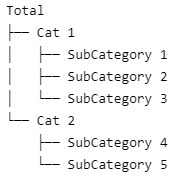

* SC1 exclusively under C1, SC4 under C2 $\implies$ **hierarchical time series**

* non exclusive $\implies$ grouped time series (not naturally disaggregating in a unique hierarchical manner)

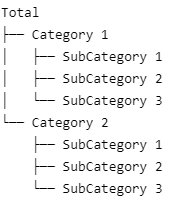

* additive across levels: in a manner consistent with the aggregation structure

\begin{equation}
T = C_1 + C_2  \\
C_1 = SC_1 + SC_2 + SC_3 \\
C_2 = SC_4 + SC_5
\end{equation}

* most time series methods focus on a particular level of aggregation, but fail to address drilling down to a more granular level.

* sum of lower level $\neq$ higher level $\implies$ incoherent forecast 

* enter HTS

* **not a methodology** (like ARIMA, ETS, Prophet) but a collection of techniques to achieve coherence

* hierarchy components can interact $\implies$ simultaneous modeling yields higher quality forecasts


Why are forecasts incoherent?

1. correct high level forecasts, issues at low levels

2. correct low level forecasts, issues with aggregation

3. combination of 1. and 2. 

## The setup

In order to ensure forecast coherence we need to break our hierarchical time series into components

### Base Forecasts

We build univariate forecasts at each individual level across the hierarchy.

### Summing matrix

* The summing matrix describes the hierarchical structure of the data

* columns = unique series on the bottom level

* rows = unique series across all levels

* values = 0/1 $\rightarrow$ which bottom-level (column) categories map to each of the hierarchies across all levels. Since picture $\gg$ 1000 words:

[source](https://towardsdatascience.com/forecast-reconciliation-in-python-8203c16254b2)

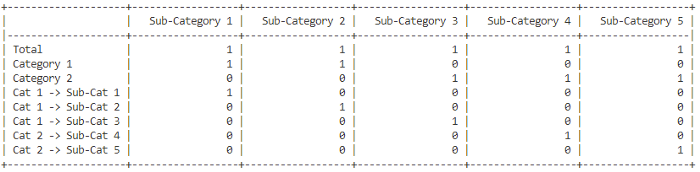


### Mapping Matrix

* multiply by summing matrix and based forecast $\implies$ coherent forecasts

* objective: reconcile the forecasts with minimal variance

* Varies per reconciliation method used 

<a id="section-zero2"></a>
# Data groundwork

In this notebook we will be using data from the [M5 competition](https://www.kaggle.com/competitions/m5-forecasting-accuracy) described on the competition website thus: 

"*In this competition, the fifth iteration, you will use hierarchical sales data from Walmart, the world’s largest company by revenue, to forecast daily sales for the next 28 days. The data, covers stores in three US States (California, Texas, and Wisconsin) and includes item level, department, product categories, and store details. In addition, it has explanatory variables such as price, promotions, day of the week, and special events. Together, this robust dataset can be used to improve forecasting accuracy.*"

For the sake of this demonstration, we will subset the data to sales of a single product across all Walmart stores in the period of interest. There are quite a few hts solutions floating around, after some thought I decided to for `hierarchicalforecast`: https://github.com/Nixtla/hierarchicalforecast. It does require a little preparation work (creating the baseline forecasts, summing matrix etc) but the ease of use makes it worth the effort.

We begin by creating the baseline forecasts:

In [6]:
# sales data calendar_df = pd.read_csv('../input/m5-forecasting-accuracy/calendar.csv', parse_dates=['date'])
calendar_df = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/calendar.csv', parse_dates=['date'])
calendar_df = calendar_df.loc[:, ['date', 'wm_yr_wk', 'd']]
df = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/sales_train_evaluation.csv')
df = df.loc[df.item_id=='FOODS_3_819']
df_T = df.melt(id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])
df_T.drop(columns=['id'], inplace=True)

sales_df = df_T.merge(calendar_df, left_on='variable', right_on='d', how='left')
sales_df.rename(columns={'value': 'sales_qty'}, inplace=True)
df = sales_df.loc[sales_df.date >= '2014-01-01', ['date', 'store_id', 'sales_qty']]
df['state_id'] = df['store_id'].str[:2]

df.head(3)

,date,store_id,sales_qty,state_id
10680,2014-01-01,CA_1,3,CA
10681,2014-01-01,CA_2,0,CA
10682,2014-01-01,CA_3,7,CA


In [7]:
# create the long format matrix: individual stores
df_ind = df.groupby(['date', 'store_id'])[['sales_qty']].sum()
df_ind.reset_index(inplace=True)
df_ind = df_ind.T.reset_index(drop=True).T
df_ind.columns = ['ds', 'unique_id', 'sales']

# create the long format matrix: state level
df_sta = df.groupby(['date', 'state_id'])[['sales_qty']].sum()
df_sta.reset_index(inplace=True)
df_sta.columns = ['ds', 'unique_id', 'sales']

# create the long format matrix: total level
df_tot = df.groupby(['date'])[['sales_qty']].sum()
df_tot.reset_index(inplace=True)
df_tot['unique_id'] = 'Total'
df_tot.columns = ['ds', 'sales', 'unique_id' ]


# combine all three
dfx = pd.concat([df_ind, df_sta, df_tot], axis = 0)
print(df_ind.shape, df_sta.shape, df_tot.shape, dfx.shape)

# format
xset = set(dfx.unique_id)
dfx.columns = ['ds','unique_id', 'y']
dfx['ds'] = pd.to_datetime(dfx['ds'])
dfx.head(10)

(8730, 3) (2619, 3) (873, 3) (12222, 3)


,ds,unique_id,y
0,2014-01-01,CA_1,3
1,2014-01-01,CA_2,0
2,2014-01-01,CA_3,7
3,2014-01-01,CA_4,0
4,2014-01-01,TX_1,0
5,2014-01-01,TX_2,1
6,2014-01-01,TX_3,1
7,2014-01-01,WI_1,1
8,2014-01-01,WI_2,0
9,2014-01-01,WI_3,3


The steps above give us a dataframe representing a hierarchical structure: 

\begin{equation}
Total = CA + TX + WI \\
CA = CA_1 + CA_2 + CA_3 + CA_4 \\
TX = TX_1 + TX_2 + TX_3 \\
WI = WI_1 + WI_2 + WI_3 \\
\end{equation}


Next step is the summing matrix: recall that $S$ is an $m$x$n$ matrix where $m$ = number of unique series across all levels (stores + states + total) and $n$ = (stores)

In [9]:
S = np.zeros((len(xset), len([f for f in xset if '_' in f])))


# rows / columns
list1 = ['Total', 'CA','CA_1','CA_2','CA_3','CA_4','TX','TX_1','TX_2','TX_3','WI','WI_1','WI_2','WI_3']
list2 = ['CA_1','CA_2','CA_3','CA_4','TX_1','TX_2','TX_3','WI_1','WI_2','WI_3']
S = pd.DataFrame(S); S.index = list1; S.columns = list2


# encode the hierarchical structure
S.loc['Total'] = 1
S.loc['CA'][['CA_1','CA_2','CA_3', 'CA_4']] = 1
S.loc['TX'][['TX_1','TX_2','TX_3']] = 1
S.loc['WI'][['WI_1','WI_2','WI_3']] = 1
for x in S.columns:
    S.loc[x][x]= 1
S = S.astype(int)
S

/tmp/ipykernel_35/4040101078.py:12: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  S.loc['CA'][['CA_1','CA_2','CA_3', 'CA_4']] = 1
/tmp/ipykernel_35/4040101078.py:13: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!

,CA_1,CA_2,CA_3,CA_4,TX_1,TX_2,TX_3,WI_1,WI_2,WI_3
Total,1,1,1,1,1,1,1,1,1,1
CA,1,1,1,1,0,0,0,0,0,0
CA_1,1,0,0,0,0,0,0,0,0,0
CA_2,0,1,0,0,0,0,0,0,0,0
CA_3,0,0,1,0,0,0,0,0,0,0
CA_4,0,0,0,1,0,0,0,0,0,0
TX,0,0,0,0,1,1,1,0,0,0
TX_1,0,0,0,0,1,0,0,0,0,0
TX_2,0,0,0,0,0,1,0,0,0,0
TX_3,0,0,0,0,0,0,1,0,0,0


The `hierarchicalforecast` implementation requires tags: a dictionary describing the composition of each level:

In [10]:
tags = {}
tags['Country'] = np.array(['Total'], dtype=object)
tags['Country/State'] = np.array(['CA', 'TX', 'WI'], dtype=object)
tags['Country/State/Store'] = np.array(['CA_1', 'CA_2', 'CA_3', 'CA_4',  
                                        'TX_1', 'TX_2', 'TX_3',
                                        'WI_1', 'WI_2', 'WI_3'], dtype=object)
tags

{'Country': array(['Total'], dtype=object),
 'Country/State': array(['CA', 'TX', 'WI'], dtype=object),
 'Country/State/Store': array(['CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1',
        'WI_2', 'WI_3'], dtype=object)}

We have the hierarchical setup ready, so let us build a set of baseline forecasts: we will use the last 7 days as test set.

In [11]:
for k in tags.keys():
    print(k)

Country
Country/State
Country/State/Store


In [12]:
horizon = 1 

x_test = dfx.groupby('unique_id').tail(horizon)
x_train = dfx.drop(x_test.index)
x_test = x_test.set_index('unique_id')
x_train = x_train.set_index('unique_id')

In [13]:
dfx.groupby('unique_id').tail(horizon)

,ds,unique_id,y
8720,2016-05-22,CA_1,5
8721,2016-05-22,CA_2,0
8722,2016-05-22,CA_3,2
8723,2016-05-22,CA_4,1
8724,2016-05-22,TX_1,0
8725,2016-05-22,TX_2,0
8726,2016-05-22,TX_3,1
8727,2016-05-22,WI_1,7
8728,2016-05-22,WI_2,0
8729,2016-05-22,WI_3,1


**As the unique_id is set as index so it doesnt counts as column in df. so we have to reset the coloumn from index set function using reset function**

In [14]:
x_train.columns

Index(['ds', 'y'], dtype='object')

In [15]:
x_train.reset_index(inplace=True)
x_train['y']=pd.to_numeric(x_train['y'])

In [16]:
x_test.shape

(14, 2)

In [17]:
x_train

,unique_id,ds,y
0,CA_1,2014-01-01,3
1,CA_2,2014-01-01,0
2,CA_3,2014-01-01,7
3,CA_4,2014-01-01,0
4,TX_1,2014-01-01,0
...,...,...,...
12198,Total,2016-05-17,11
12199,Total,2016-05-18,22
12200,Total,2016-05-19,9
12201,Total,2016-05-20,21


-----------------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------------

# ML MODEL INTEGRATION in the ***base forecast***


In [18]:
mlf1 = MLForecast(
    models = [LinearRegression()],
    lags=[365],
    freq = 'D'
)

In [19]:
mlf1.fit(x_train)
# mlf1.predict(x_test)
x_hat = mlf1.predict(h = horizon)

In [20]:
x_hat.head(3)

,unique_id,ds,LinearRegression
0,CA,2016-05-22,4.066977
1,CA_1,2016-05-22,1.021142
2,CA_2,2016-05-22,1.021142


In [21]:
x_train.head(3)

,unique_id,ds,y
0,CA_1,2014-01-01,3
1,CA_2,2014-01-01,0
2,CA_3,2014-01-01,7


What do error metrics look like for the raw (unreconciled) forecasts?

In [22]:
xmat = pd.merge(left = x_test, right = x_hat, on = ['ds', 'unique_id'])
xmat.head(4)

,ds,unique_id,y,LinearRegression
0,2016-05-22,CA_1,5,1.021142
1,2016-05-22,CA_2,0,1.021142
2,2016-05-22,CA_3,2,4.066977
3,2016-05-22,CA_4,1,1.021142


In [23]:
tr = xmat['y']
type(tr)

pandas.core.series.Series

# setting unique_id as index as the furthur approaches need the such format

In [24]:
# xmat = pd.merge(left = x_test, right = x_hat, on = ['ds', 'unique_id'])
# # xmat.columns = [['ds', 'y', 'pred']]
xmat = xmat.set_index('unique_id')


In [25]:
xmat.head(4)

,ds,y,LinearRegression
unique_id,,,
CA_1,2016-05-22,5,1.021142
CA_2,2016-05-22,0,1.021142
CA_3,2016-05-22,2,4.066977
CA_4,2016-05-22,1,1.021142


In [26]:
print('overall rmse: ' + str(my_rmse(xmat['y'], xmat['LinearRegression'])))
for k in tags.keys():
    print(k + ' rmse: ' + str(my_rmse(xmat.loc[tags[k]]['y'], xmat.loc[tags[k]]['LinearRegression'])))


overall rmse: 3.6519
Country rmse: 9.278
Country/State rmse: 3.2319
Country/State/Store rmse: 2.6324


-----------------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------------

# **Apply the mlf1 model in the below approaches**

-----------------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------------

.

<a id="section-one"></a>
# BottomUp

* forecast each of the disaggregated series at the lowest level of the hierarchy

* add up to the higher levels

[Source](https://medium.com/opex-analytics/hierarchical-time-series-101-734a3da15426):

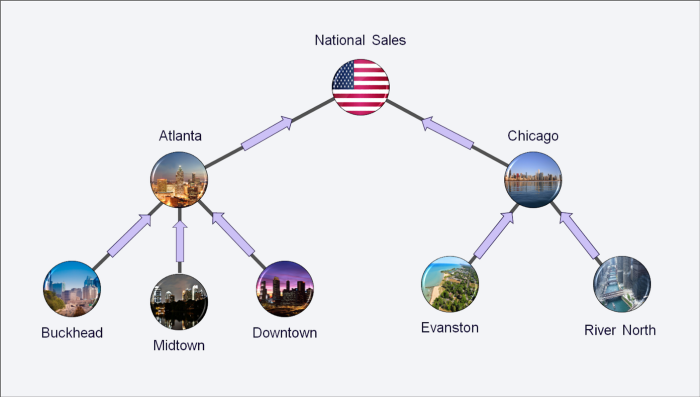

In [27]:
# Reconcile the base predictions
reconcilers = [
    BottomUp()
]

hrec = HierarchicalReconciliation(reconcilers = reconcilers)
#x_hat_rec = hrec.reconcile(x_hat, x_train, S, tags)
x_hat_rec = hrec.reconcile(x_hat, S, tags)

In [28]:
def mse(y, y_hat):
    return np.mean((y-y_hat)**2)

evaluator = HierarchicalEvaluation(evaluators=[mse])
evaluator.evaluate(Y_hat_df = x_hat_rec, Y_test_df = x_test, 
                   tags=tags, benchmark='LinearRegression')

,,index,LinearRegression,index/BottomUp,LinearRegression/BottomUp
level,metric,,,,
Overall,mse-scaled,3.299238,1.0,22.259147,0.432623
Country,mse-scaled,0.74348,1.0,29.042187,0.000089
Country/State,mse-scaled,2.68074,1.0,37.913317,0.366171
Country/State/Store,mse-scaled,6.753885,1.0,6.753885,1.0


In [29]:
xmat = pd.merge(left = x_test, right = x_hat_rec, on = ['ds', 'unique_id'])
xmat.head(3)

,ds,y,index,LinearRegression,index/BottomUp,LinearRegression/BottomUp
unique_id,,,,,,
CA_1,2016-05-22,5,1,1.021142,1.0,1.021142
CA_2,2016-05-22,0,2,1.021142,2.0,1.021142
CA_3,2016-05-22,2,3,4.066977,3.0,4.066977


In [30]:
xmat.columns

Index(['ds', 'y', 'index', 'LinearRegression', 'index/BottomUp',
       'LinearRegression/BottomUp'],
      dtype='object')

In [31]:
x_test.head(3)

,ds,y
unique_id,,
CA_1,2016-05-22,5
CA_2,2016-05-22,0
CA_3,2016-05-22,2


In [32]:
x_hat_rec.head(3)

,index,ds,LinearRegression,index/BottomUp,LinearRegression/BottomUp
unique_id,,,,,
Total,9,2016-05-22,7.721979,67.0,16.912254
CA,0,2016-05-22,4.066977,10.0,7.130401
CA_1,1,2016-05-22,1.021142,1.0,1.021142


In [33]:
x_hat_rec.drop(columns=['index/BottomUp'], inplace=True)
x_hat_rec.drop(columns=['index'], inplace=True)

In [34]:
x_hat_rec.head(3)

,ds,LinearRegression,LinearRegression/BottomUp
unique_id,,,
Total,2016-05-22,7.721979,16.912254
CA,2016-05-22,4.066977,7.130401
CA_1,2016-05-22,1.021142,1.021142


In [35]:
xmat = pd.merge(left = x_test, right = x_hat_rec, on = ['ds', 'unique_id'])
xmat.columns = [['ds', 'y', 'pred_orig', 'pred_reconciled']]
mse1 = my_rmse(xmat['y'], xmat['pred_orig'])
mse2 = my_rmse(xmat['y'], xmat['pred_reconciled'])
print('overall rmse: ' + str(mse1) + ' -> ' + str(mse2))

for k in tags.keys():
    mse1 = my_rmse(xmat.loc[tags[k]]['y'], xmat.loc[tags[k]]['pred_orig'])
    mse2 = my_rmse(xmat.loc[tags[k]]['y'], xmat.loc[tags[k]]['pred_reconciled'])

    print(k + ' rmse: ' + str(mse1) + ' -> ' + str(mse2) )


overall rmse: 3.6519 -> 2.402
Country rmse: 9.278 -> 0.0877
Country/State rmse: 3.2319 -> 1.9557
Country/State/Store rmse: 2.6324 -> 2.6324


In [36]:
xmat

,ds,y,pred_orig,pred_reconciled
unique_id,,,,
CA_1,2016-05-22,5,1.021142,1.021142
CA_2,2016-05-22,0,1.021142,1.021142
CA_3,2016-05-22,2,4.066977,4.066977
CA_4,2016-05-22,1,1.021142,1.021142
TX_1,2016-05-22,0,1.021142,1.021142
TX_2,2016-05-22,0,1.630309,1.630309
TX_3,2016-05-22,1,1.021142,1.021142
WI_1,2016-05-22,7,1.021142,1.021142
WI_2,2016-05-22,0,1.630309,1.630309


In [38]:
(xmat['pred_reconciled']).iloc[2,0]

4.0669765

In [39]:
xmat

,ds,y,pred_orig,pred_reconciled
unique_id,,,,
CA_1,2016-05-22,5,1.021142,1.021142
CA_2,2016-05-22,0,1.021142,1.021142
CA_3,2016-05-22,2,4.066977,4.066977
CA_4,2016-05-22,1,1.021142,1.021142
TX_1,2016-05-22,0,1.021142,1.021142
TX_2,2016-05-22,0,1.630309,1.630309
TX_3,2016-05-22,1,1.021142,1.021142
WI_1,2016-05-22,7,1.021142,1.021142
WI_2,2016-05-22,0,1.630309,1.630309


* no information lost due to aggregation

* ignores relationships between series 

* lower levels can be noisy

<a id="section-two"></a>
# TopDown

This approach is the opposite of the previous one: we forecast the highest level series and the disaggregate it based on proportions:
- average historical proportions:
\begin{equation*}
p_j = \frac{1}{T} \sum_{t=1}^T \frac{y_{j,t}}{y_t}
\end{equation*}
- proportions of historical averages: 
\begin{equation*}
p_j = \frac{\sum_{t=1}^T \frac{y_{j,t}}{T}}{\sum_{t=1}^T \frac{y_{t}}{y_t}}
\end{equation*}


[Source](https://medium.com/opex-analytics/hierarchical-time-series-101-734a3da15426):

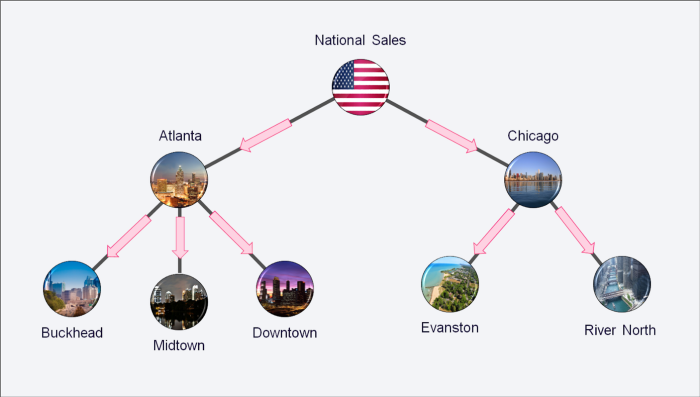

In [40]:
# Reconcile the base predictions
reconcilers = [
    TopDown(method='forecast_proportions')
]

hrec = HierarchicalReconciliation(reconcilers = reconcilers)
# x_hat_rec = hrec.reconcile(x_hat, x_train, S, tags)
x_hat_rec = hrec.reconcile(x_hat, S, tags)

In [41]:
evaluator = HierarchicalEvaluation(evaluators=[mse])
evaluator.evaluate(Y_hat_df = x_hat_rec, Y_test_df = x_test, 
                   tags=tags, benchmark='LinearRegression')

,,index,LinearRegression,index/TopDown_method-forecast_proportions,LinearRegression/TopDown_method-forecast_proportions
level,metric,,,,
Overall,mse-scaled,3.299238,1.0,1.070167,1.055697
Country,mse-scaled,0.74348,1.0,0.74348,1.0
Country/State,mse-scaled,2.68074,1.0,2.297777,1.463258
Country/State/Store,mse-scaled,6.753885,1.0,0.920876,0.940588


In [42]:
x_hat_rec.drop(columns=['index/TopDown_method-forecast_proportions'], inplace=True)
x_hat_rec.drop(columns=['index'], inplace=True)

In [43]:
xmat = pd.merge(left = x_test, right = x_hat_rec, on = ['ds', 'unique_id'])
xmat.head(3)

,ds,y,LinearRegression,LinearRegression/TopDown_method-forecast_proportions
unique_id,,,,
CA_1,2016-05-22,5,1.021142,0.460609
CA_2,2016-05-22,0,1.021142,0.460609
CA_3,2016-05-22,2,4.066977,1.834504


In [44]:
xmat.columns = [['ds', 'y', 'pred_orig', 'pred_reconciled']]

In [45]:

# xmat.columns = [['ds', 'y', 'pred_orig', 'pred_reconciled']]

mse1 = my_rmse(xmat['y'], xmat['pred_orig'])
mse2 = my_rmse(xmat['y'], xmat['pred_reconciled'])
print('overall rmse: ' + str(mse1) + ' -> ' + str(mse2))

for k in tags.keys():
    mse1 = my_rmse(xmat.loc[tags[k]]['y'], xmat.loc[tags[k]]['pred_orig'])
    mse2 = my_rmse(xmat.loc[tags[k]]['y'], xmat.loc[tags[k]]['pred_reconciled'])

    print(k + ' rmse: ' + str(mse1) + ' -> ' + str(mse2) )


overall rmse: 3.6519 -> 3.7522
Country rmse: 9.278 -> 9.278
Country/State rmse: 3.2319 -> 3.9094
Country/State/Store rmse: 2.6324 -> 2.553


<a id="section-three"></a>
# MiddleOut

This approach combines the previous two:

* bottom-up and top-down together

* pick a middle level, use bottoms-up to find overall sales

* disintegrate sales using proportion to find the most granual level values


[Source](https://medium.com/opex-analytics/hierarchical-time-series-101-734a3da15426):

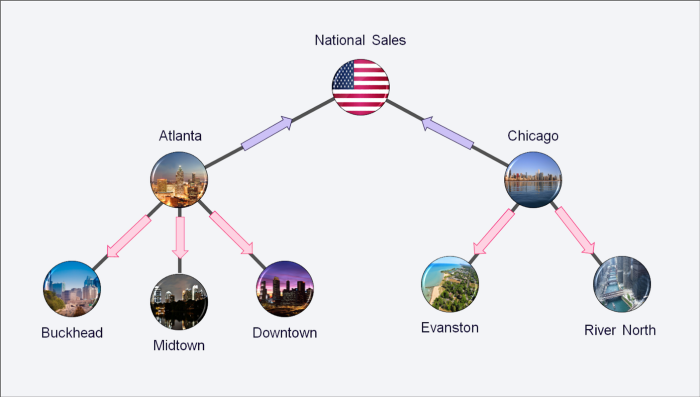

In [47]:
# Reconcile the base predictions
reconcilers = [
    MiddleOut(middle_level = 'Country/State', top_down_method='forecast_proportions')
]

hrec = HierarchicalReconciliation(reconcilers = reconcilers)
# x_hat_rec = hrec.reconcile(x_hat, x_train, S, tags).fillna(0)
x_hat_rec = hrec.reconcile(x_hat, S, tags).fillna(0)


In [48]:
evaluator = HierarchicalEvaluation(evaluators=[mse])
evaluator.evaluate(Y_hat_df = x_hat_rec, Y_test_df = x_test, 
                   tags=tags, benchmark='LinearRegression')


,,index,LinearRegression,index/MiddleOut_middle_level-Country/State_top_down_method-forecast_proportions,LinearRegression/MiddleOut_middle_level-Country/State_top_down_method-forecast_proportions
level,metric,,,,
Overall,mse-scaled,3.299238,1.0,0.841546,0.790893
Country,mse-scaled,0.74348,1.0,0.046467,0.608212
Country/State,mse-scaled,2.68074,1.0,2.68074,1.0
Country/State/Store,mse-scaled,6.753885,1.0,0.997567,0.923274


In [49]:
x_hat_rec.drop(columns=['index/MiddleOut_middle_level-Country/State_top_down_method-forecast_proportions'], inplace=True)
x_hat_rec.drop(columns=['index'], inplace=True)
x_hat_rec.head(3)

,ds,LinearRegression,LinearRegression/MiddleOut_middle_level-Country/State_top_down_method-forecast_proportions
unique_id,,,
Total,2016-05-22,7.721979,9.764261
CA,2016-05-22,4.066977,4.066977
CA_1,2016-05-22,1.021142,0.582430


In [50]:
xmat = pd.merge(left = x_test, right = x_hat_rec, on = ['ds', 'unique_id'])
xmat.columns = [['ds', 'y', 'pred_orig', 'pred_reconciled']]
mse1 = my_rmse(xmat['y'], xmat['pred_orig'])
mse2 = my_rmse(xmat['y'], xmat['pred_reconciled'])
print('overall rmse: ' + str(mse1) + ' -> ' + str(mse2))

for k in tags.keys():
    mse1 = my_rmse(xmat.loc[tags[k]]['y'], xmat.loc[tags[k]]['pred_orig'])
    mse2 = my_rmse(xmat.loc[tags[k]]['y'], xmat.loc[tags[k]]['pred_reconciled'])

    print(k + ' rmse: ' + str(mse1) + ' -> ' + str(mse2) )


overall rmse: 3.6519 -> 3.2477
Country rmse: 9.278 -> 7.2357
Country/State rmse: 3.2319 -> 3.2319
Country/State/Store rmse: 2.6324 -> 2.5294


<a id="section-four"></a>
# MinTrace

* predict for all the layers independently

* construct a mapping matrix minimising the overall variance of the forecasts 

* assumes forecasts are unbiased 

* original paper: https://www.tandfonline.com/doi/abs/10.1080/01621459.2018.1448825?journalCode=uasa20
 
 
[Source](https://medium.com/opex-analytics/hierarchical-time-series-101-734a3da15426):


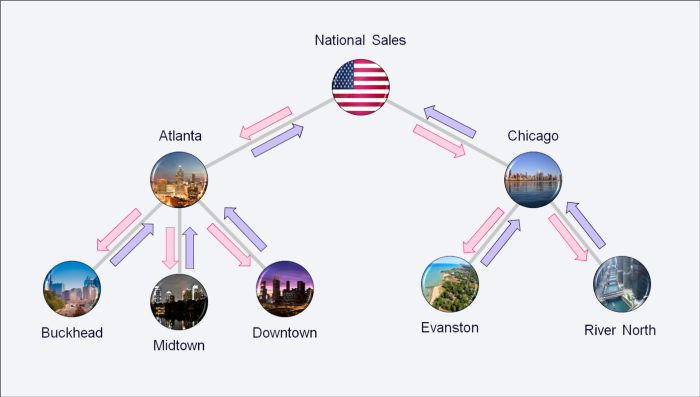

In [52]:
# Reconcile the base predictions
reconcilers = [
    MinTrace(method='ols'),
]

hrec = HierarchicalReconciliation(reconcilers = reconcilers)
# x_hat_rec = hrec.reconcile(x_hat, x_train, S, tags)
x_hat_rec = hrec.reconcile(x_hat, S, tags)

In [53]:
x_test.head()

,ds,y
unique_id,,
CA_1,2016-05-22,5
CA_2,2016-05-22,0
CA_3,2016-05-22,2
CA_4,2016-05-22,1
TX_1,2016-05-22,0


In [54]:
evaluator = HierarchicalEvaluation(evaluators=[mse])
evaluator.evaluate(Y_hat_df = x_hat_rec, Y_test_df = x_test, 
                   tags=tags, benchmark='LinearRegression')

,,index,LinearRegression,index/MinTrace_method-ols,LinearRegression/MinTrace_method-ols
level,metric,,,,
Overall,mse-scaled,3.299238,1.0,1.388722,0.956845
Country,mse-scaled,0.74348,1.0,0.066576,0.774284
Country/State,mse-scaled,2.68074,1.0,4.556889,1.147616
Country/State/Store,mse-scaled,6.753885,1.0,1.598542,1.097369


In [55]:
xmat.columns

MultiIndex([(             'ds',),
            (              'y',),
            (      'pred_orig',),
            ('pred_reconciled',)],
           )

In [56]:
x_hat_rec.drop(columns=['index/MinTrace_method-ols'], inplace=True)
x_hat_rec.drop(columns=['index'], inplace=True)

In [57]:
xmat = pd.merge(left = x_test, right = x_hat_rec, on = ['ds', 'unique_id'])

In [58]:
xmat.head()

,ds,y,LinearRegression,LinearRegression/MinTrace_method-ols
unique_id,,,,
CA_1,2016-05-22,5,1.021142,0.185662
CA_2,2016-05-22,0,1.021142,0.185662
CA_3,2016-05-22,2,4.066977,3.231497
CA_4,2016-05-22,1,1.021142,0.185662
TX_1,2016-05-22,0,1.021142,0.232078


In [59]:
xmat.columns

Index(['ds', 'y', 'LinearRegression', 'LinearRegression/MinTrace_method-ols'], dtype='object')

In [60]:
xmat.head()

,ds,y,LinearRegression,LinearRegression/MinTrace_method-ols
unique_id,,,,
CA_1,2016-05-22,5,1.021142,0.185662
CA_2,2016-05-22,0,1.021142,0.185662
CA_3,2016-05-22,2,4.066977,3.231497
CA_4,2016-05-22,1,1.021142,0.185662
TX_1,2016-05-22,0,1.021142,0.232078


In [61]:

xmat.columns = [['ds', 'y', 'pred_orig', 'pred_reconciled']]
mse1 = my_rmse(xmat['y'], xmat['pred_orig'])
mse2 = my_rmse(xmat['y'], xmat['pred_reconciled'])
print('overall rmse: ' + str(mse1) + ' -> ' + str(mse2))

for k in tags.keys():
    mse1 = my_rmse(xmat.loc[tags[k]]['y'], xmat.loc[tags[k]]['pred_orig'])
    mse2 = my_rmse(xmat.loc[tags[k]]['y'], xmat.loc[tags[k]]['pred_reconciled'])

    print(k + ' rmse: ' + str(mse1) + ' -> ' + str(mse2) )


overall rmse: 3.6519 -> 3.5722
Country rmse: 9.278 -> 8.164
Country/State rmse: 3.2319 -> 3.4622
Country/State/Store rmse: 2.6324 -> 2.7575


.

# Optimal Combination

In [62]:
reconcilers = [
    OptimalCombination(method='ols'),
]

hrec = HierarchicalReconciliation(reconcilers = reconcilers)
# x_hat_rec = hrec.reconcile(x_hat, x_train, S, tags)
x_hat_rec = hrec.reconcile(x_hat, S, tags)
x_hat_rec.head()

,index,ds,LinearRegression,index/OptimalCombination_method-ols,LinearRegression/OptimalCombination_method-ols
unique_id,,,,,
Total,9,2016-05-22,7.721979,14.606061,8.835952
CA,0,2016-05-22,4.066977,-2.484848,3.788484
CA_1,1,2016-05-22,1.021142,-2.121212,0.185662
CA_2,2,2016-05-22,1.021142,-1.121212,0.185662
CA_3,3,2016-05-22,4.066977,-0.121212,3.231497


In [63]:
evaluator = HierarchicalEvaluation(evaluators=[mse])
x = evaluator.evaluate(Y_hat_df = x_hat_rec, Y_test_df = x_test, 
                   tags=tags, benchmark='LinearRegression')

In [64]:
x.head()

,,index,LinearRegression,index/OptimalCombination_method-ols,LinearRegression/OptimalCombination_method-ols
level,metric,,,,
Overall,mse-scaled,3.299238,1.0,1.388722,0.956845
Country,mse-scaled,0.74348,1.0,0.066576,0.774284
Country/State,mse-scaled,2.68074,1.0,4.556889,1.147616
Country/State/Store,mse-scaled,6.753885,1.0,1.598542,1.097369


In [65]:
(evaluator.evaluate(Y_hat_df = x_hat_rec, Y_test_df = x_test, 
                   tags=tags, benchmark='LinearRegression')).columns

Index(['index', 'LinearRegression', 'index/OptimalCombination_method-ols',
       'LinearRegression/OptimalCombination_method-ols'],
      dtype='object')

In [66]:
x_hat_rec.drop(columns=['index/OptimalCombination_method-ols'], inplace=True)
x_hat_rec.drop(columns=['index'], inplace=True)

In [67]:
x_hat_rec.head()

,ds,LinearRegression,LinearRegression/OptimalCombination_method-ols
unique_id,,,
Total,2016-05-22,7.721979,8.835952
CA,2016-05-22,4.066977,3.788484
CA_1,2016-05-22,1.021142,0.185662
CA_2,2016-05-22,1.021142,0.185662
CA_3,2016-05-22,4.066977,3.231497


In [68]:
xmat = pd.merge(left = x_test, right = x_hat_rec, on = ['ds', 'unique_id'])
xmat.columns = [['ds', 'y', 'pred_orig', 'pred_reconciled']]

In [69]:
xmat.head()

,ds,y,pred_orig,pred_reconciled
unique_id,,,,
CA_1,2016-05-22,5,1.021142,0.185662
CA_2,2016-05-22,0,1.021142,0.185662
CA_3,2016-05-22,2,4.066977,3.231497
CA_4,2016-05-22,1,1.021142,0.185662
TX_1,2016-05-22,0,1.021142,0.232078


In [70]:

mse1 = my_rmse(xmat['y'], xmat['pred_orig'])
mse2 = my_rmse(xmat['y'], xmat['pred_reconciled'])
print('overall rmse: ' + str(mse1) + ' -> ' + str(mse2))

for k in tags.keys():
    mse1 = my_rmse(xmat.loc[tags[k]]['y'], xmat.loc[tags[k]]['pred_orig'])
    mse2 = my_rmse(xmat.loc[tags[k]]['y'], xmat.loc[tags[k]]['pred_reconciled'])

    print(k + ' rmse: ' + str(mse1) + ' -> ' + str(mse2) )


overall rmse: 3.6519 -> 3.5722
Country rmse: 9.278 -> 8.164
Country/State rmse: 3.2319 -> 3.4622
Country/State/Store rmse: 2.6324 -> 2.7575


 . 


.

In [71]:
%pip install xgboost

Note: you may need to restart the kernel to use updated packages.


# Applying all algo

In [77]:
%pip install openpyxl



Note: you may need to restart the kernel to use updated packages.


In [78]:
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import TweedieRegressor

from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.svm  import SVR
from sklearn.svm  import LinearSVR
from sklearn.neural_network import MLPRegressor

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import BaggingRegressor

from sklearn.tree import DecisionTreeRegressor

from sklearn.neighbors import KNeighborsRegressor
import xgboost as xg 

import os

# MAIN CODE

In [79]:
# observations = 5
# # h = 1

# D= [
#     'LinearRegression',
#     'Lasso',
#     'Ridge',
#     'ElasticNet',
#     'HuberRegressor',
#     'SGDRegressor',
#     'TweedieRegressor',
#     'AdaBoostRegressor',
#     'RandomForestRegressor',
#     'GradientBoostingRegressor',
#     'LinearSVR',
#     'MLPRegressor',
#     'SVR',
#     'ExtraTreesRegressor',
#     'BaggingRegressor',
#     'DecisionTreeRegressor',
#     'KNeighborsRegressor'
#                                ]



# collection_of_all = pd.DataFrame()
# coll_rmse =pd.DataFrame()
# coll_smape =pd.DataFrame()

# aug_df = pd.DataFrame()
# # aug_df['models']=D

# for j in range(0,17,1):
#     print('Model:::::::::::::::::::::::::::::::',j)
#     if j==0:         
#         model=LinearRegression()
#         name='1.LinearRegression'
#     elif j==1:
#         model=Lasso()
#         name='2.Lasso'
#     elif j==2:
#         model=Ridge()
#         name='3.Ridge'
#     elif j==3:
#         model=ElasticNet()
#         name='4.ElasticNet'
#     elif j==4:
#         model=HuberRegressor()
#         name='5.HuberRegressor'
#     elif j==5:
#         model=SGDRegressor()
#         name='6.SGDRegressor'
#     elif j==6:
#         model=TweedieRegressor()
#         name='7.TweedieRegressor'
#     elif j==7:
#         model=AdaBoostRegressor()
#         name='8.AdaBoostRegressor'
#     elif j==8:
#         model=RandomForestRegressor()
#         name='9.RandomForestRegressor'
#     elif j==9:
#         model=GradientBoostingRegressor()
#         name='10.GradientBoostingRegressor'
#     elif j==10:
#         model=LinearSVR()
#         name='11.LinearSVR'
#     elif j==11:
#         model=MLPRegressor()
#         name='12.MLPRegressor'
#     elif j==12:
#         model=SVR()
#         name='13.SVR'
#     elif j==13:
#         model=ExtraTreesRegressor()
#         name='14.ExtraTreesRegressor'
#     elif j==14:
#         model=BaggingRegressor()
#         name='15.BaggingRegressor'
#     elif j==15:
#         model=DecisionTreeRegressor()
#         name='16.DecisionTreeRegressor'
#     elif j==16:
#         model=KNeighborsRegressor()
#         name='17.KNeighborsRegressor'
    
#     # os.makedirs(name, exist_ok=True)
#     agg_mean_for_each_model = pd.DataFrame()
#     agg_smape = pd.DataFrame()
#     agg_rmse = pd.DataFrame()

#     file1 = 0
    
#     for i in range(0,5,1):
#         print('approach:::::::::::::::::::::::::::::::',i)
#         if i==0:         
#             recon=BottomUp()
#             approached = 'BottomUp'
#         elif i==1:         
#                 recon=TopDown(method='forecast_proportions')
#                 approached = 'TopDown'
#         elif i==2:         
#                 recon=MiddleOut(middle_level = 'Country/State', top_down_method='forecast_proportions')
#                 approached = 'MiddleOut'
#         elif i==3:         
#                 recon=MinTrace(method='ols')
#                 approached = 'MinTrace'
#         elif i==4:         
#                 recon=OptimalCombination(method='ols')
#                 approached = 'OptimalCombination'
                
        
#         final_df = pd.DataFrame()
#         msedf = pd.DataFrame()
#         smapedf = pd.DataFrame()
        
        
#         folder_name = name  # Extracting the initial word
#         folder_path = os.path.join('.', folder_name)  # Creating folder path
#         if not os.path.exists(folder_path):  # Creating the folder if dont exist
#             os.makedirs(folder_path)
            
#         file = os.path.join(folder_path, f'{name}_{approached}_accuracy.xlsx')
#         file1 = os.path.join(folder_path, f'{name}__mean.xlsx')
#         # file1 = file
#         mlf2 = MLForecast(
#                             models = [model],
#                             lags=[30],
#                             freq = 'D'
#                         )
        
#         reconcilers = [recon]
        
#         mlf2.fit(x_train)
#         # mlf1.predict(x_test)
#         # 10 iterations
#         for k in range(observations):
           
#             x_hat = mlf2.predict(horizon)
            
#             it_df=pd.DataFrame()
#             # temp dataframe for performance data

#             hrec = HierarchicalReconciliation(reconcilers = reconcilers)
#             x_hat_rec = hrec.reconcile(x_hat, S, tags)
            
#             ben = name.split('.')[1]
            
#             evaluator = HierarchicalEvaluation(evaluators=[mse])
#             perf = evaluator.evaluate(Y_hat_df = x_hat_rec, Y_test_df = x_test,tags=tags ,benchmark=ben)
            
#             col_data = ['overall', ' country', 'counttry/state', 'country/state/store']
#             col = 'levell'
            
            
#             perf[col] = col_data
            
#             perf2 = perf.iloc[:,-2:]
            
#             pivot_df = perf2.pivot_table(index=perf2.index, columns=perf2.columns[1], values=perf2.columns[0], aggfunc='first')

#             # Reset index to make 'index' as a column instead of index
#             pivot_df.reset_index(drop=True, inplace=True)
#             sum_row = pivot_df.sum()
#             # Convert the sum row to a DataFrame with a single row
#             sum_df = pd.DataFrame([sum_row])  
#                     #sumdf = formatted perf df  
#             final_df = pd.concat([final_df,sum_df])
                        
            
        
#         final_df.to_excel(file,index=False )
        
         
        
#         each_appr_mean_df = pd.DataFrame(final_df.mean()).transpose()   
         
#         agg_mean_for_each_model = pd.concat([agg_mean_for_each_model,each_appr_mean_df])
         

#     d = ['BottomUp', 'TopDown','MiddleOut','MinTrace', 'OptimalCombination']
     
#     agg_mean_for_each_model_labeled = agg_mean_for_each_model
#     agg_mean_for_each_model_labeled['approach'] = d
    
#     agg_mean_for_each_model_labeled.to_excel(file1,index=False)    
    
#     fp = agg_mean_for_each_model_labeled.iloc[:,-2]
#     tp = pd.DataFrame(fp).transpose()
#     tp.reset_index(drop=True, inplace=True)
#     aug_df = pd.concat([aug_df,tp])
#     print(aug_df)

     
#     max_row_index = agg_mean_for_each_model['overall'].idxmin()
#     row_with_max_value = agg_mean_for_each_model.iloc[max_row_index]
#     dh = pd.DataFrame(row_with_max_value).transpose()
#     collection_of_all = pd.concat([collection_of_all,dh])
    
     


    

    
# # =================================

 
# aug_df.columns = ['BottomUp','TopDown','MiddleOut','MinTrace','OptimalCombination']
# aug_df.insert(loc=0,column='model',value=D)
# aug_df.to_excel('one_step_ahead.xlsx',index=False)

# collection_of_all['models'] = D
# coll_smape['MODELS']=D
# coll_rmse['MODELS']=D

# filename = './' + '__ highest collection [ highest(mean(every Aproach)) ]__.xlsx'
# collection_of_all.to_excel(filename,index=False)

 




In [80]:
D= [
    'LinearRegression',
    'Lasso',
    'Ridge',
    'ElasticNet',
    'HuberRegressor',
    'SGDRegressor',
    'TweedieRegressor',
    'AdaBoostRegressor',
    'RandomForestRegressor',
    'GradientBoostingRegressor',
    'LinearSVR',
    'MLPRegressor',
    'SVR',
    'ExtraTreesRegressor',
    'BaggingRegressor',
    'DecisionTreeRegressor',
    'KNeighborsRegressor'
                               ]

# 8 horizon whole code

In [80]:
Hrange = 8
observations = 100


for horizon in range(1,Hrange+1):

    x_test = dfx.groupby('unique_id').tail(horizon)
    x_train = dfx.drop(x_test.index)
    x_test = x_test.set_index('unique_id')
    x_train = x_train.set_index('unique_id')
    
    x_train.reset_index(inplace=True)
    x_train['y']=pd.to_numeric(x_train['y'])


    D= [
        'LinearRegression',
        'Lasso',
        'Ridge',
        'ElasticNet',
        'HuberRegressor',
        'SGDRegressor',
        'TweedieRegressor',
        'AdaBoostRegressor',
        'RandomForestRegressor',
        'GradientBoostingRegressor',
        'LinearSVR',
        'MLPRegressor',
        'SVR',
        'ExtraTreesRegressor',
        'BaggingRegressor',
        'DecisionTreeRegressor',
        'KNeighborsRegressor'
                                ]



    collection_of_all = pd.DataFrame()
    coll_rmse =pd.DataFrame()
    coll_smape =pd.DataFrame()

    aug_df = pd.DataFrame()
    # aug_df['models']=D

    for j in range(0,17,1):
        print('Model:::::::::::::::::::::::::::::::',j)
        if j==0:         
            model=LinearRegression()
            name='1.LinearRegression'
        elif j==1:
            model=Lasso()
            name='2.Lasso'
        elif j==2:
            model=Ridge()
            name='3.Ridge'
        elif j==3:
            model=ElasticNet()
            name='4.ElasticNet'
        elif j==4:
            model=HuberRegressor()
            name='5.HuberRegressor'
        elif j==5:
            model=SGDRegressor()
            name='6.SGDRegressor'
        elif j==6:
            model=TweedieRegressor()
            name='7.TweedieRegressor'
        elif j==7:
            model=AdaBoostRegressor()
            name='8.AdaBoostRegressor'
        elif j==8:
            model=RandomForestRegressor()
            name='9.RandomForestRegressor'
        elif j==9:
            model=GradientBoostingRegressor()
            name='10.GradientBoostingRegressor'
        elif j==10:
            model=LinearSVR()
            name='11.LinearSVR'
        elif j==11:
            model=MLPRegressor()
            name='12.MLPRegressor'
        elif j==12:
            model=SVR()
            name='13.SVR'
        elif j==13:
            model=ExtraTreesRegressor()
            name='14.ExtraTreesRegressor'
        elif j==14:
            model=BaggingRegressor()
            name='15.BaggingRegressor'
        elif j==15:
            model=DecisionTreeRegressor()
            name='16.DecisionTreeRegressor'
        elif j==16:
            model=KNeighborsRegressor()
            name='17.KNeighborsRegressor'
        
        # os.makedirs(name, exist_ok=True)
        agg_mean_for_each_model = pd.DataFrame()
        agg_smape = pd.DataFrame()
        agg_rmse = pd.DataFrame()

        file1 = 0
        
        for i in range(0,5,1):
            print('approach:::::::::::::::::::::::::::::::',i)
            if i==0:         
                recon=BottomUp()
                approached = 'BottomUp'
            elif i==1:         
                    recon=TopDown(method='forecast_proportions')
                    approached = 'TopDown'
            elif i==2:         
                    recon=MiddleOut(middle_level = 'Country/State', top_down_method='forecast_proportions')
                    approached = 'MiddleOut'
            elif i==3:         
                    recon=MinTrace(method='ols')
                    approached = 'MinTrace'
            elif i==4:         
                    recon=OptimalCombination(method='ols')
                    approached = 'OptimalCombination'
                    
            
            final_df = pd.DataFrame()
            msedf = pd.DataFrame()
            smapedf = pd.DataFrame()
            
            
            folder_name = name  # Extracting the initial word
            folder_path = os.path.join('.',str(horizon)+'_step ahead', folder_name)  # Creating folder path
            if not os.path.exists(folder_path):  # Creating the folder if dont exist
                os.makedirs(folder_path)
                
            file = os.path.join(folder_path, f'{name}_{approached}_accuracy.xlsx')
            file1 = os.path.join(folder_path, f'{name}__mean.xlsx')
            # file1 = file
            mlf2 = MLForecast(
                                models = [model],
                                lags=[30],
                                freq = 'D'
                            )
            
            reconcilers = [recon]
            
            mlf2.fit(x_train)
            # mlf1.predict(x_test)
            # 10 iterations
            for k in range(observations):
            
                x_hat = mlf2.predict(horizon)
                
                it_df=pd.DataFrame()
                # temp dataframe for performance data

                hrec = HierarchicalReconciliation(reconcilers = reconcilers)
                x_hat_rec = hrec.reconcile(x_hat, S, tags)
                
                ben = name.split('.')[1]
                
                evaluator = HierarchicalEvaluation(evaluators=[mse])
                perf = evaluator.evaluate(Y_hat_df = x_hat_rec, Y_test_df = x_test,tags=tags ,benchmark=ben)
                
                col_data = ['overall', ' country', 'counttry/state', 'country/state/store']
                col = 'levell'
                
                
                perf[col] = col_data
                
                perf2 = perf.iloc[:,-2:]
                
                pivot_df = perf2.pivot_table(index=perf2.index, columns=perf2.columns[1], values=perf2.columns[0], aggfunc='first')

                # Reset index to make 'index' as a column instead of index
                pivot_df.reset_index(drop=True, inplace=True)
                sum_row = pivot_df.sum()
                # Convert the sum row to a DataFrame with a single row
                sum_df = pd.DataFrame([sum_row])  
                        #sumdf = formatted perf df  
                final_df = pd.concat([final_df,sum_df])
                            
                
            
            final_df.to_excel(file,index=False )
            
            
            
            each_appr_mean_df = pd.DataFrame(final_df.mean()).transpose()   
            
            agg_mean_for_each_model = pd.concat([agg_mean_for_each_model,each_appr_mean_df])
            

        d = ['BottomUp', 'TopDown','MiddleOut','MinTrace', 'OptimalCombination']
        
        agg_mean_for_each_model_labeled = agg_mean_for_each_model
        agg_mean_for_each_model_labeled['approach'] = d
        
        agg_mean_for_each_model_labeled.to_excel(file1,index=False)    
        
        fp = agg_mean_for_each_model_labeled.iloc[:,-2]
        tp = pd.DataFrame(fp).transpose()
        tp.reset_index(drop=True, inplace=True)
        aug_df = pd.concat([aug_df,tp])
        # print(aug_df)

        
        max_row_index = agg_mean_for_each_model['overall'].idxmin()
        row_with_max_value = agg_mean_for_each_model.iloc[max_row_index]
        dh = pd.DataFrame(row_with_max_value).transpose()
        collection_of_all = pd.concat([collection_of_all,dh])
        
        


        

        
    # =================================


    aug_df.columns = ['BottomUp','TopDown','MiddleOut','MinTrace','OptimalCombination']
    aug_df.insert(loc=0,column='model',value=D)
    # aug_df.to_excel('one_step_ahead.xlsx',index=False)

    collection_of_all['models'] = D
    coll_smape['MODELS']=D
    coll_rmse['MODELS']=D

    # folder_path = os.path.join('.',str(horizon)+'_step ahead', folder_name)  # Creating folder path
    #         if not os.path.exists(folder_path):  # Creating the folder if dont exist
    #             os.makedirs(folder_path)

    # filename = './' + '__ highest collection [ highest(mean(every Aproach)) ]__.xlsx'
    filename = os.path.join('.',str(horizon)+'_step_ahead')
    collection_of_all.to_excel(f'{horizon}_step ahead\_HIGHEST_PERFORMANCE_DATA.xlsx',index=False)






Model::::::::::::::::::::::::::::::: 0

approach::::::::::::::::::::::::::::::: 0

approach::::::::::::::::::::::::::::::: 1

approach::::::::::::::::::::::::::::::: 2

approach::::::::::::::::::::::::::::::: 3

approach::::::::::::::::::::::::::::::: 4

Model::::::::::::::::::::::::::::::: 1

approach::::::::::::::::::::::::::::::: 0

approach::::::::::::::::::::::::::::::: 1

approach::::::::::::::::::::::::::::::: 2

approach::::::::::::::::::::::::::::::: 3

approach::::::::::::::::::::::::::::::: 4

Model::::::::::::::::::::::::::::::: 2

approach::::::::::::::::::::::::::::::: 0

approach::::::::::::::::::::::::::::::: 1

approach::::::::::::::::::::::::::::::: 2

approach::::::::::::::::::::::::::::::: 3

approach::::::::::::::::::::::::::::::: 4

Model::::::::::::::::::::::::::::::: 3

approach::::::::::::::::::::::::::::::: 0

approach::::::::::::::::::::::::::::::: 1

approach::::::::::::::::::::::::::::::: 2

approach::::::::::::::::::::::::::::::: 3

approach:::::::::::::::

C:\Users\DELL\.conda\envs\deeplearninggpu\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.

  warnings.warn(


approach::::::::::::::::::::::::::::::: 2


C:\Users\DELL\.conda\envs\deeplearninggpu\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.

  warnings.warn(


approach::::::::::::::::::::::::::::::: 3


C:\Users\DELL\.conda\envs\deeplearninggpu\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.

  warnings.warn(


approach::::::::::::::::::::::::::::::: 4


C:\Users\DELL\.conda\envs\deeplearninggpu\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.

  warnings.warn(


Model::::::::::::::::::::::::::::::: 11

approach::::::::::::::::::::::::::::::: 0

approach::::::::::::::::::::::::::::::: 1

approach::::::::::::::::::::::::::::::: 2

approach::::::::::::::::::::::::::::::: 3

approach::::::::::::::::::::::::::::::: 4

Model::::::::::::::::::::::::::::::: 12

approach::::::::::::::::::::::::::::::: 0

approach::::::::::::::::::::::::::::::: 1

approach::::::::::::::::::::::::::::::: 2

approach::::::::::::::::::::::::::::::: 3

approach::::::::::::::::::::::::::::::: 4

Model::::::::::::::::::::::::::::::: 13

approach::::::::::::::::::::::::::::::: 0

approach::::::::::::::::::::::::::::::: 1

approach::::::::::::::::::::::::::::::: 2

approach::::::::::::::::::::::::::::::: 3

approach::::::::::::::::::::::::::::::: 4

Model::::::::::::::::::::::::::::::: 14

approach::::::::::::::::::::::::::::::: 0

approach::::::::::::::::::::::::::::::: 1

approach::::::::::::::::::::::::::::::: 2

approach::::::::::::::::::::::::::::::: 3

approach:::::::::::

C:\Users\DELL\.conda\envs\deeplearninggpu\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.

  warnings.warn(


approach::::::::::::::::::::::::::::::: 1


C:\Users\DELL\.conda\envs\deeplearninggpu\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.

  warnings.warn(


approach::::::::::::::::::::::::::::::: 2

approach::::::::::::::::::::::::::::::: 3


C:\Users\DELL\.conda\envs\deeplearninggpu\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.

  warnings.warn(


approach::::::::::::::::::::::::::::::: 4


C:\Users\DELL\.conda\envs\deeplearninggpu\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.

  warnings.warn(


Model::::::::::::::::::::::::::::::: 11

approach::::::::::::::::::::::::::::::: 0

approach::::::::::::::::::::::::::::::: 1

approach::::::::::::::::::::::::::::::: 2

approach::::::::::::::::::::::::::::::: 3

approach::::::::::::::::::::::::::::::: 4

Model::::::::::::::::::::::::::::::: 12

approach::::::::::::::::::::::::::::::: 0

approach::::::::::::::::::::::::::::::: 1

approach::::::::::::::::::::::::::::::: 2

approach::::::::::::::::::::::::::::::: 3

approach::::::::::::::::::::::::::::::: 4

Model::::::::::::::::::::::::::::::: 13

approach::::::::::::::::::::::::::::::: 0

approach::::::::::::::::::::::::::::::: 1

approach::::::::::::::::::::::::::::::: 2

approach::::::::::::::::::::::::::::::: 3

approach::::::::::::::::::::::::::::::: 4

Model::::::::::::::::::::::::::::::: 14

approach::::::::::::::::::::::::::::::: 0

approach::::::::::::::::::::::::::::::: 1

approach::::::::::::::::::::::::::::::: 2

approach::::::::::::::::::::::::::::::: 3

approach:::::::::::

C:\Users\DELL\.conda\envs\deeplearninggpu\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.

  warnings.warn(


approach::::::::::::::::::::::::::::::: 1


C:\Users\DELL\.conda\envs\deeplearninggpu\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.

  warnings.warn(


approach::::::::::::::::::::::::::::::: 2

approach::::::::::::::::::::::::::::::: 3

approach::::::::::::::::::::::::::::::: 4


C:\Users\DELL\.conda\envs\deeplearninggpu\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.

  warnings.warn(


Model::::::::::::::::::::::::::::::: 11

approach::::::::::::::::::::::::::::::: 0

approach::::::::::::::::::::::::::::::: 1

approach::::::::::::::::::::::::::::::: 2

approach::::::::::::::::::::::::::::::: 3

approach::::::::::::::::::::::::::::::: 4

Model::::::::::::::::::::::::::::::: 12

approach::::::::::::::::::::::::::::::: 0

approach::::::::::::::::::::::::::::::: 1

approach::::::::::::::::::::::::::::::: 2

approach::::::::::::::::::::::::::::::: 3

approach::::::::::::::::::::::::::::::: 4

Model::::::::::::::::::::::::::::::: 13

approach::::::::::::::::::::::::::::::: 0

approach::::::::::::::::::::::::::::::: 1

approach::::::::::::::::::::::::::::::: 2

approach::::::::::::::::::::::::::::::: 3

approach::::::::::::::::::::::::::::::: 4

Model::::::::::::::::::::::::::::::: 14

approach::::::::::::::::::::::::::::::: 0

approach::::::::::::::::::::::::::::::: 1

approach::::::::::::::::::::::::::::::: 2

approach::::::::::::::::::::::::::::::: 3

approach:::::::::::

C:\Users\DELL\.conda\envs\deeplearninggpu\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.

  warnings.warn(


approach::::::::::::::::::::::::::::::: 1


C:\Users\DELL\.conda\envs\deeplearninggpu\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.

  warnings.warn(


approach::::::::::::::::::::::::::::::: 2


C:\Users\DELL\.conda\envs\deeplearninggpu\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.

  warnings.warn(


approach::::::::::::::::::::::::::::::: 3


C:\Users\DELL\.conda\envs\deeplearninggpu\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.

  warnings.warn(


approach::::::::::::::::::::::::::::::: 4


C:\Users\DELL\.conda\envs\deeplearninggpu\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.

  warnings.warn(


Model::::::::::::::::::::::::::::::: 11

approach::::::::::::::::::::::::::::::: 0

approach::::::::::::::::::::::::::::::: 1

approach::::::::::::::::::::::::::::::: 2

approach::::::::::::::::::::::::::::::: 3

approach::::::::::::::::::::::::::::::: 4

Model::::::::::::::::::::::::::::::: 12

approach::::::::::::::::::::::::::::::: 0

approach::::::::::::::::::::::::::::::: 1

approach::::::::::::::::::::::::::::::: 2

approach::::::::::::::::::::::::::::::: 3

approach::::::::::::::::::::::::::::::: 4

Model::::::::::::::::::::::::::::::: 13

approach::::::::::::::::::::::::::::::: 0

approach::::::::::::::::::::::::::::::: 1

approach::::::::::::::::::::::::::::::: 2

approach::::::::::::::::::::::::::::::: 3

approach::::::::::::::::::::::::::::::: 4

Model::::::::::::::::::::::::::::::: 14

approach::::::::::::::::::::::::::::::: 0

approach::::::::::::::::::::::::::::::: 1

approach::::::::::::::::::::::::::::::: 2

approach::::::::::::::::::::::::::::::: 3

approach:::::::::::

C:\Users\DELL\.conda\envs\deeplearninggpu\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.

  warnings.warn(


approach::::::::::::::::::::::::::::::: 1


C:\Users\DELL\.conda\envs\deeplearninggpu\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.

  warnings.warn(


approach::::::::::::::::::::::::::::::: 2

approach::::::::::::::::::::::::::::::: 3


C:\Users\DELL\.conda\envs\deeplearninggpu\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.

  warnings.warn(


approach::::::::::::::::::::::::::::::: 4


C:\Users\DELL\.conda\envs\deeplearninggpu\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.

  warnings.warn(


Model::::::::::::::::::::::::::::::: 11

approach::::::::::::::::::::::::::::::: 0

approach::::::::::::::::::::::::::::::: 1

approach::::::::::::::::::::::::::::::: 2

approach::::::::::::::::::::::::::::::: 3

approach::::::::::::::::::::::::::::::: 4

Model::::::::::::::::::::::::::::::: 12

approach::::::::::::::::::::::::::::::: 0

approach::::::::::::::::::::::::::::::: 1

approach::::::::::::::::::::::::::::::: 2

approach::::::::::::::::::::::::::::::: 3

approach::::::::::::::::::::::::::::::: 4

Model::::::::::::::::::::::::::::::: 13

approach::::::::::::::::::::::::::::::: 0

approach::::::::::::::::::::::::::::::: 1

approach::::::::::::::::::::::::::::::: 2

approach::::::::::::::::::::::::::::::: 3

approach::::::::::::::::::::::::::::::: 4

Model::::::::::::::::::::::::::::::: 14

approach::::::::::::::::::::::::::::::: 0

approach::::::::::::::::::::::::::::::: 1

approach::::::::::::::::::::::::::::::: 2

approach::::::::::::::::::::::::::::::: 3

approach:::::::::::

KeyboardInterrupt: 

In [ ]:
filename

# horizon stacked data for every APPROACH 

In [82]:
import pandas as pd
Hrange = 8

fr = {
     'models':[],
     'h=1':[],
     'h=2':[],
     'h=3':[],
     'h=4':[],
     'h=5':[],
     'h=6':[],
     'h=7':[],
     'h=8':[],
}

D= [
    'LinearRegression',
    'Lasso',
    'Ridge',
    'ElasticNet',
    'HuberRegressor',
    'SGDRegressor',
    'TweedieRegressor',
    'AdaBoostRegressor',
    'RandomForestRegressor',
    'GradientBoostingRegressor',
    'LinearSVR',
    'MLPRegressor',
    'SVR',
    'ExtraTreesRegressor',
    'BaggingRegressor',
    'DecisionTreeRegressor',
    'KNeighborsRegressor'
                            ]

"LinearRegression",
"Lasso",
"Ridge",
"ElasticNet",
"HuberRegressor",
"SGDRegressor",
"TweedieRegressor",
"AdaBoostRegressor",
"RandomForestRegressor",
"GradientBoostingRegressor",
"LinearSVR",
"MLPRegressor",
"SVR",
"ExtraTreesRegressor",
"BaggingRegressor",
"DecisionTreeRegressor",
"KNeighborsRegressor",

overallBU pd.DataFrame(fr)
overallBU['models'] =D 
countryBU = pd.DataFrame(fr)
countryBU['models'] =D 
stateBU = pd.DataFrame(fr)
stateBU['models'] =D 
storeBU = pd.DataFrame(fr)
storeBU['models'] =D 

overallTD = pd.DataFrame(fr)
overallTD['models'] =D 
countryTD = pd.DataFrame(fr)
countryTD['models'] =D 
stateTD = pd.DataFrame(fr)
stateTD['models'] =D 
storeTD = pd.DataFrame(fr)
storeTD['models'] =D 

overallMO = pd.DataFrame(fr)
overallMO['models'] =D 
countryMO = pd.DataFrame(fr)
countryMO['models'] =D 
stateMO = pd.DataFrame(fr)
stateMO['models'] =D 
storeMO = pd.DataFrame(fr)
storeMO['models'] =D 

overallMT = pd.DataFrame(fr)
overallMT['models'] =D 
countryMT = pd.DataFrame(fr)
countryMT['models'] =D 
stateMT = pd.DataFrame(fr)
stateMT['models'] =D 
storeMT = pd.DataFrame(fr)
storeMT['models'] =D 

overallOC = pd.DataFrame(fr)
overallOC['models'] =D 
countryOC = pd.DataFrame(fr)
countryOC['models'] =D 
stateOC = pd.DataFrame(fr)
stateOC['models'] =D 
storeOC = pd.DataFrame(fr)
storeOC['models'] =D 






for horizon in range(1,Hrange+1):

    print('horizon:::::::::::::::',horizon)
    for j in range(0,17,1):
        print('Model:::::::::::::::::::::::::::::::',j)
        if j==0:         
            model=LinearRegression()
            name='1.LinearRegression'
        elif j==1:
            model=Lasso()
            name='2.Lasso'
        elif j==2:
            model=Ridge()
            name='3.Ridge'
        elif j==3:
            model=ElasticNet()
            name='4.ElasticNet'
        elif j==4:
            model=HuberRegressor()
            name='5.HuberRegressor'
        elif j==5:
            model=SGDRegressor()
            name='6.SGDRegressor'
        elif j==6:
            model=TweedieRegressor()
            name='7.TweedieRegressor'
        elif j==7:
            model=AdaBoostRegressor()
            name='8.AdaBoostRegressor'
        elif j==8:
            model=RandomForestRegressor()
            name='9.RandomForestRegressor'
        elif j==9:
            model=GradientBoostingRegressor()
            name='10.GradientBoostingRegressor'
        elif j==10:
            model=LinearSVR()
            name='11.LinearSVR'
        elif j==11:
            model=MLPRegressor()
            name='12.MLPRegressor'
        elif j==12:
            model=SVR()
            name='13.SVR'
        elif j==13:
            model=ExtraTreesRegressor()
            name='14.ExtraTreesRegressor'
        elif j==14:
            model=BaggingRegressor()
            name='15.BaggingRegressor'
        elif j==15:
            model=DecisionTreeRegressor()
            name='16.DecisionTreeRegressor'
        elif j==16:
            model=KNeighborsRegressor()
            name='17.KNeighborsRegressor'
        
        
        file1 = 0
        
         
            
            
        folder_name = name  # Extracting the initial word
        folder_path = os.path.join('.',str(horizon)+'_step ahead', folder_name)  # Creating folder path
        if not os.path.exists(folder_path):  # Creating the folder if dont exist
            os.makedirs(folder_path)
            
         
        file1 = os.path.join(folder_path, f'{name}__mean.xlsx')
         
        
        tempdf = pd.read_excel(file1)

        overallBU.loc[ overallBU['models'] == name.split('.')[1],f'h={horizon}'   ] = tempdf.iloc[0,3]
        countryBU.loc[ countryBU['models'] == name.split('.')[1],f'h={horizon}'   ] = tempdf.iloc[0,0]
        stateBU.loc[ stateBU['models'] == name.split('.')[1],f'h={horizon}'   ] =   tempdf.iloc[0,2]
        storeBU.loc[ storeBU['models'] == name.split('.')[1],f'h={horizon}'   ] =   tempdf.iloc[0,1]

        overallTD.loc[ overallTD['models'] == name.split('.')[1],f'h={horizon}'   ] = tempdf.iloc[0,3]
        countryTD.loc[ countryTD['models'] == name.split('.')[1],f'h={horizon}'   ] = tempdf.iloc[0,0]
        stateTD.loc[ stateTD['models'] == name.split('.')[1],f'h={horizon}'   ] =   tempdf.iloc[0,2]
        storeTD.loc[ storeTD['models'] == name.split('.')[1],f'h={horizon}'   ] =   tempdf.iloc[0,1]

        overallMO.loc[ overallMO['models'] == name.split('.')[1],f'h={horizon}'   ] = tempdf.iloc[0,3]
        countryMO.loc[ countryMO['models'] == name.split('.')[1],f'h={horizon}'   ] = tempdf.iloc[0,0]
        stateMO.loc[ stateMO['models'] == name.split('.')[1],f'h={horizon}'   ] =   tempdf.iloc[0,2]
        storeMO.loc[ storeMO['models'] == name.split('.')[1],f'h={horizon}'   ] =   tempdf.iloc[0,1]

        overallMT.loc[ overallMT['models'] == name.split('.')[1],f'h={horizon}'   ] = tempdf.iloc[0,3]
        countryMT.loc[ countryMT['models'] == name.split('.')[1],f'h={horizon}'   ] = tempdf.iloc[0,0]
        stateMT.loc[ stateMT['models'] == name.split('.')[1],f'h={horizon}'   ] =   tempdf.iloc[0,2]
        storeMT.loc[ storeMT['models'] == name.split('.')[1],f'h={horizon}'   ] =   tempdf.iloc[0,1]

        overallOC.loc[ overallOC['models'] == name.split('.')[1],f'h={horizon}'   ] = tempdf.iloc[0,3]
        countryOC.loc[ countryOC['models'] == name.split('.')[1],f'h={horizon}'   ] = tempdf.iloc[0,0]
        stateOC.loc[ stateOC['models'] == name.split('.')[1],f'h={horizon}'   ] =   tempdf.iloc[0,2]
        storeOC.loc[ storeOC['models'] == name.split('.')[1],f'h={horizon}'   ] =   tempdf.iloc[0,1]


rootPath = '.\Final_Report_[_with_8_horizon_]'
if not os.path.exists(rootPath):  # Creating the folder if dont exist
    os.makedirs(rootPath)
    

# storeBU['average'] = storeBU.mean(axis=1)


overallBU['average'] = overallBU.mean(axis = 1) 
overallBU.to_excel(f'{rootPath}\overallBU.xlsx',index=False)

overallTD['average'] = overallTD.mean(axis = 1) 
overallTD.to_excel(f'{rootPath}\overallTD.xlsx',index=False)

overallMO['average'] = overallMO.mean(axis = 1) 
overallMO.to_excel(f'{rootPath}\overallMO.xlsx',index=False)

overallMT['average'] = overallMT.mean(axis = 1) 
overallMT.to_excel(f'{rootPath}\overallMT.xlsx',index=False)

overallOC['average'] = overallOC.mean(axis = 1) 
overallOC.to_excel(f'{rootPath}\overallOC.xlsx',index=False)


countryBU['average'] = countryBU.mean(axis = 1) 
countryBU.to_excel(f'{rootPath}\countryBU.xlsx',index=False)

countryTD['average'] = countryTD.mean(axis = 1) 
countryTD.to_excel(f'{rootPath}\countryTD.xlsx',index=False)

countryMO['average'] = countryMO.mean(axis = 1) 
countryMO.to_excel(f'{rootPath}\countryMO.xlsx',index=False)

countryMT['average'] = countryMT.mean(axis = 1) 
countryMT.to_excel(f'{rootPath}\countryMT.xlsx',index=False)

countryOC['average'] = countryOC.mean(axis = 1) 
countryOC.to_excel(f'{rootPath}\countryOC.xlsx',index=False)


stateBU['average'] = stateBU.mean(axis = 1) 
stateBU.to_excel(f'{rootPath}\stateBU.xlsx',index=False)

stateTD['average'] = stateTD.mean(axis = 1) 
stateTD.to_excel(f'{rootPath}\stateTD.xlsx',index=False)

stateMO['average'] = stateMO.mean(axis = 1) 
stateMO.to_excel(f'{rootPath}\stateMO.xlsx',index=False)

stateMT['average'] = stateMT.mean(axis = 1) 
stateMT.to_excel(f'{rootPath}\stateMT.xlsx',index=False)

stateOC['average'] = stateOC.mean(axis = 1) 
stateOC.to_excel(f'{rootPath}\stateOC.xlsx',index=False)


storeBU['average'] = storeBU.mean(axis = 1) 
storeBU.to_excel(f'{rootPath}\storeBU.xlsx',index=False)

storeTD['average'] = storeTD.mean(axis = 1) 
storeTD.to_excel(f'{rootPath}\storeTD.xlsx',index=False)

storeMO['average'] = storeMO.mean(axis = 1) 
storeMO.to_excel(f'{rootPath}\storeMO.xlsx',index=False)

storeMT['average'] = storeMT.mean(axis = 1) 
storeMT.to_excel(f'{rootPath}\storeMT.xlsx',index=False)

storeOC['average'] = storeOC.mean(axis = 1) 
storeOC.to_excel(f'{rootPath}\storeOC.xlsx',index=False)


    
  

horizon::::::::::::::: 1

Model::::::::::::::::::::::::::::::: 0

Model::::::::::::::::::::::::::::::: 1

Model::::::::::::::::::::::::::::::: 2

Model::::::::::::::::::::::::::::::: 3

Model::::::::::::::::::::::::::::::: 4

Model::::::::::::::::::::::::::::::: 5

Model::::::::::::::::::::::::::::::: 6

Model::::::::::::::::::::::::::::::: 7

Model::::::::::::::::::::::::::::::: 8

Model::::::::::::::::::::::::::::::: 9

Model::::::::::::::::::::::::::::::: 10

Model::::::::::::::::::::::::::::::: 11

Model::::::::::::::::::::::::::::::: 12

Model::::::::::::::::::::::::::::::: 13

Model::::::::::::::::::::::::::::::: 14

Model::::::::::::::::::::::::::::::: 15

Model::::::::::::::::::::::::::::::: 16

horizon::::::::::::::: 2

Model::::::::::::::::::::::::::::::: 0

Model::::::::::::::::::::::::::::::: 1

Model::::::::::::::::::::::::::::::: 2

Model::::::::::::::::::::::::::::::: 3

Model::::::::::::::::::::::::::::::: 4

Model::::::::::::::::::::::::::::::: 5

Model::::::::::::::::

C:\Users\DELL\AppData\Local\Temp\ipykernel_7736\1111539478.py:196: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.

  overallBU['average'] = overallBU.mean(axis = 1)

C:\Users\DELL\AppData\Local\Temp\ipykernel_7736\1111539478.py:199: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.

  overallTD['average'] = overallTD.mean(axis = 1)

C:\Users\DELL\AppData\Local\Temp\ipykernel_7736\1111539478.py:202: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.

  overallMO['average'] = overallMO.mean(axis = 1)

C

# ============================================================================


.

# FORMATTED DATA
==========================

In [ ]:
f = {
    'models':[],
    'rmse':[],
    'smape':[]

}

BottomUpdf=pd.DataFrame(f)
BottomUpdf['models'] = D

TopDowndf=pd.DataFrame(f)
TopDowndf['models'] = D

MiddleOutdf=pd.DataFrame(f)
MiddleOutdf['models'] = D

MinTracedf=pd.DataFrame(f)
MinTracedf['models'] = D

OptimalCombinationdf=pd.DataFrame(f)
OptimalCombinationdf['models'] = D

# for i in range(0,5,1):
#     print('approach:::::::::::::::::::::::::::::::',i)
#     if i==0:         
#         recon=BottomUp()
#         approached = 'BottomUp'
#     elif i==1:         
#             recon=TopDown(method='forecast_proportions')
#             approached = 'TopDown'
#     elif i==2:         
#             recon=MiddleOut(middle_level = 'Country/State', top_down_method='forecast_proportions')
#             approached = 'MiddleOut'
#     elif i==3:         
#             recon=MinTrace(method='ols')
#             approached = 'MinTrace'
#     elif i==4:         
#             recon=OptimalCombination(method='ols')
#             approached = 'OptimalCombination'


#======================================================================

for j in range(0,17,1):
    print('Model:::::::::::::::::::::::::::::::',j)
    if j==0:         
        model=LinearRegression()
        name='1.LinearRegression'
    elif j==1:
        model=Lasso()
        name='2.Lasso'
    elif j==2:
        model=Ridge()
        name='3.Ridge'
    elif j==3:
        model=ElasticNet()
        name='4.ElasticNet'
    elif j==4:
        model=HuberRegressor()
        name='5.HuberRegressor'
    elif j==5:
        model=SGDRegressor()
        name='6.SGDRegressor'
    elif j==6:
        model=TweedieRegressor()
        name='7.TweedieRegressor'
    elif j==7:
        model=AdaBoostRegressor()
        name='8.AdaBoostRegressor'
    elif j==8:
        model=RandomForestRegressor()
        name='9.RandomForestRegressor'
    elif j==9:
        model=GradientBoostingRegressor()
        name='10.GradientBoostingRegressor'
    elif j==10:
        model=LinearSVR()
        name='11.LinearSVR'
    elif j==11:
        model=MLPRegressor()
        name='12.MLPRegressor'
    elif j==12:
        model=SVR()
        name='13.SVR'
    elif j==13:
        model=ExtraTreesRegressor()
        name='14.ExtraTreesRegressor'
    elif j==14:
        model=BaggingRegressor()
        name='15.BaggingRegressor'
    elif j==15:
        model=DecisionTreeRegressor()
        name='16.DecisionTreeRegressor'
    elif j==16:
        model=KNeighborsRegressor()
        name='17.KNeighborsRegressor'
    
    folder_path = os.path.join('.', name)  # Creating folder path
    # if not os.path.exists(folder_path):  # Creating the folder if dont exist
        # os.makedirs(folder_path)
    # file = os.path.join(folder_path, f'{name}_{approached}_accuracy.xlsx')
    file1 = os.path.join(folder_path, f'{name}__mean.xlsx')

    tempRMSE = pd.read_excel(file1, sheet_name='agg_rmse')
    tempSMAPE = pd.read_excel(file1, sheet_name='agg_smape')
    
    btValrmse = tempRMSE.iloc[0,0]
    tdValrmse = tempRMSE.iloc[1,0]
    moValrmse = tempRMSE.iloc[2,0]
    mtValrmse = tempRMSE.iloc[3,0]
    ocValrmse = tempRMSE.iloc[4,0]

    btValsmape = tempSMAPE.iloc[0,0]
    tdValsmape = tempSMAPE.iloc[1,0]
    moValsmape = tempSMAPE.iloc[2,0]
    mtValsmape = tempSMAPE.iloc[3,0]
    ocValsmape = tempSMAPE.iloc[4,0]

    BottomUpdf.loc[BottomUpdf['models']== name.split('.')[1],'rmse'] = btValrmse
    BottomUpdf.loc[BottomUpdf['models']== name.split('.')[1],'smape'] = btValsmape

    TopDowndf.loc[BottomUpdf['models']== name.split('.')[1],'rmse'] = tdValrmse
    TopDowndf.loc[BottomUpdf['models']== name.split('.')[1],'smape'] = tdValsmape

    MiddleOutdf.loc[BottomUpdf['models']== name.split('.')[1],'rmse'] = moValrmse
    MiddleOutdf.loc[BottomUpdf['models']== name.split('.')[1],'smape'] = moValsmape

    MinTracedf.loc[BottomUpdf['models']== name.split('.')[1],'rmse'] = mtValrmse
    MinTracedf.loc[BottomUpdf['models']== name.split('.')[1],'smape'] = mtValsmape

    OptimalCombinationdf.loc[BottomUpdf['models']== name.split('.')[1],'rmse'] = ocValrmse
    OptimalCombinationdf.loc[BottomUpdf['models']== name.split('.')[1],'smape'] = ocValsmape



BottomUpdf.to_excel('Reconciled_bottomup.xlsx',index=False)
TopDowndf.to_excel('Reconciled_TopDown.xlsx',index=False)
MiddleOutdf.to_excel('Reconciled_MiddleOutdf.xlsx',index=False)
MinTracedf.to_excel('Reconciled_MinTracedf.xlsx',index=False)
OptimalCombinationdf.to_excel('Reconciled_OptimalCombinationdf.xlsx',index=False)
#==========================================================================
    



.

# ===================================================================

# friedman test

In [2]:
pip install pandas scipy openpyxl










Note: you may need to restart the kernel to use updated packages.


In [ ]:
# from scipy.stats import friedmanchisquare

# # Define your data
# group1 = [3, 4, 2, 5]
# group2 = [4, 5, 1, 3]
# group3 = [2, 3, 5, 4]

# # Perform the Friedmann Test
# statistic, p_value = friedmanchisquare(group1, group2, group3)

# # Print the results
# print("Friedman Test Statistic:", statistic)
# print("P-value:", p_value)

# # Interpret the results
# alpha = 0.05
# if p_value < alpha:
#     print("Reject the null hypothesis. There is a statistically significant difference between groups.")
# else:
#     print("Fail to reject the null hypothesis. There is no statistically significant difference between groups.")


In [5]:
import pandas as pd
import numpy as np
from scipy.stats import friedmanchisquare
import os

folder_path = 'D:\HierarchialTSarinrudhir\ORIGINAL DIR\Final_Report_[_with_8_horizon_]'
filetype=[]
fstat= []
fp=[]
c=[]
for x in os.listdir(folder_path):
    if x.endswith('.xlsx'):
        file_path = os.path.join(folder_path, x)
        df = pd.read_excel(file_path, engine='openpyxl')
        rows_as_arrays = [np.array(row[1:-1]) for index, row in df.iterrows()]

        # Convert the list of arrays into a 2D NumPy array
        rows_array = np.array(rows_as_arrays)
        # Perform the Friedman test
        statistic, p_value = friedmanchisquare(*rows_array)

        formatted_p = '{:.13f}'.format(p_value)

        lab = file_path[-12:]
        if lab[:5] == 'erall':
            lab = 'ov'+lab
        elif lab[:5] == 'untry':
            lab = 'co' + lab 

        filetype.append(lab)
        fstat.append(statistic)
        fp.append(formatted_p)

        # Interpret the results
        alpha = 0.05
        if p_value < alpha:
            # print("Reject the null hypothesis. There is a statistically significant difference between groups.")
            c.append("Reject the null hypothesis. There is a statistically significant DIFFRENCE IN MODELS.")
        else:
            c.append("Fail to reject the null hypothesis. no statistically difference.")
        # print()
            
        friedmanTest = pd.DataFrame({
                                        'level & approach':filetype,
                                        'statistic value':fstat,
                                        'pvalue':fp,
                                        'result':c

        })

        friedmanTest.to_excel('friedman_test_results.xlsx',index=False)



# ============================================================

# stacked data

In [ ]:
import pandas as pd
import os

# stepcount = []
# iterations=[]
# list_LinearRegression=[]
# list_Lasso=[]
# list_Ridge=[]
# list_ElasticNet=[]
# list_HuberRegressor=[]
# list_SGDRegressor=[]
# list_TweedieRegressor=[]
# list_AdaBoostRegressor=[]
# list_RandomForestRegressor=[]
# list_GradientBoostingRegressor=[]
# list_LinearSVR=[]
# list_MLPRegressor=[]
# list_SVR=[]
# list_ExtraTreesRegressor=[]
# list_BaggingRegressor=[]
# list_DecisionTreeRegressor=[]
# list_KNeighborsRegresso=[]

dict ={
    'LinearRegression':[],
    'Lasso':[],
    'Ridge':[],
    'ElasticNet':[],
    'HuberRegressor':[],
    'SGDRegressor':[],
    'TweedieRegressor':[],
    'AdaBoostRegressor':[],
    'RandomForestRegressor':[],
    'GradientBoostingRegressor':[],
    'LinearSVR':[],
    'MLPRegressor':[],
    'SVR':[],
    'ExtraTreesRegressor':[],
    'BaggingRegressor':[],
    'DecisionTreeRegressor':[],
    'KNeighborsRegressor':[],

}


# overallBU = pd.DataFrame(dict)
# countryBU = pd.DataFrame(dict)
# stateBU = pd.DataFrame(dict)
# storeBU = pd.DataFrame(dict)

# overallTD = pd.DataFrame(dict)
# countryTD = pd.DataFrame(dict)
# stateTD = pd.DataFrame(dict)
# storeTD = pd.DataFrame(dict)

# overallMO = pd.DataFrame(dict)
# countryMO = pd.DataFrame(dict)
# stateMO = pd.DataFrame(dict)
# storeMO = pd.DataFrame(dict)

# overallMT = pd.DataFrame(dict)
# countryMT = pd.DataFrame(dict)
# stateMT = pd.DataFrame(dict)
# storeMT = pd.DataFrame(dict)

# overallOC = pd.DataFrame(dict)
# countryOC = pd.DataFrame(dict)
# stateOC = pd.DataFrame(dict)
# storeOC = pd.DataFrame(dict)

final_overallBU = pd.DataFrame(dict)
final_countryBU = pd.DataFrame(dict)
final_stateBU = pd.DataFrame(dict)
final_storeBU = pd.DataFrame(dict)

final_overallTD = pd.DataFrame(dict)
final_countryTD = pd.DataFrame(dict)
final_stateTD = pd.DataFrame(dict)
final_storeTD = pd.DataFrame(dict)

final_overallMO = pd.DataFrame(dict)
final_countryMO = pd.DataFrame(dict)
final_stateMO = pd.DataFrame(dict)
final_storeMO = pd.DataFrame(dict)

final_overallMT = pd.DataFrame(dict)
final_countryMT = pd.DataFrame(dict)
final_stateMT = pd.DataFrame(dict)
final_storeMT = pd.DataFrame(dict)

final_overallOC = pd.DataFrame(dict)
final_countryOC = pd.DataFrame(dict)
final_stateOC = pd.DataFrame(dict)
final_storeOC = pd.DataFrame(dict)

root_directory = r'D:\rudhir\hierarchichal_Time_Series\final data and code\HTS DATA AND REPORTS-20240329T175936Z-001\HTS DATA AND REPORTS\matlab_freidman_data'

#final_df = 

# Loop through each of the 8 directories
for directory in os.listdir(root_directory):
    directory_path = os.path.join(root_directory, directory)
    if not os.path.isdir(directory_path):
        continue  # Skip if it's not a directory
    
    #tempdf  * 8 
    overallBU = pd.DataFrame(dict)
    countryBU = pd.DataFrame(dict)
    stateBU = pd.DataFrame(dict)
    storeBU = pd.DataFrame(dict)

    overallTD = pd.DataFrame(dict)
    countryTD = pd.DataFrame(dict)
    stateTD = pd.DataFrame(dict)
    storeTD = pd.DataFrame(dict)

    overallMO = pd.DataFrame(dict)
    countryMO = pd.DataFrame(dict)
    stateMO = pd.DataFrame(dict)
    storeMO = pd.DataFrame(dict)

    overallMT = pd.DataFrame(dict)
    countryMT = pd.DataFrame(dict)
    stateMT = pd.DataFrame(dict)
    storeMT = pd.DataFrame(dict)

    overallOC = pd.DataFrame(dict)
    countryOC = pd.DataFrame(dict)
    stateOC = pd.DataFrame(dict)
    storeOC = pd.DataFrame(dict)
    # Loop through each of the 17 subdirectories
    for subdirectory in os.listdir(directory_path):
        subdirectory_path = os.path.join(directory_path, subdirectory)
        if not os.path.isdir(subdirectory_path):
            continue  # Skip if it's not a directory
        col = (subdirectory)
        col = (col.split('.')[1])
        
        
        # Loop through each of the 4 Excel files in the subdirectory
        for filename in os.listdir(subdirectory_path):
            if filename.endswith('.xlsx'):  # Check if it's an Excel file
                file_path = os.path.join(subdirectory_path, filename)
                if filename[-9:-5] == 'mean':continue
                
                # Read the Excel file using pandas
                df = pd.read_excel(file_path)
                
                # Process the dataframe as needed
                dc = df[' country']
                dsto = df['country/state/store']
                dsta = df['counttry/state']
                do = df['overall']
                
                # print(file_path[-20:])
                
                # ttomUp_accuracy.xlsx
                # dleOut_accuracy.xlsx
                # nTrace_accuracy.xlsx
                # nation_accuracy.xlsx
                # opDown_accuracy.xlsx
                
                
                if file_path[-20:] == 'ttomUp_accuracy.xlsx':
                    overallBU[col] = do
                    # overallBU = pd.concat([overallBU,temp_overallBU])
                    
                    countryBU[col] = dc
                    # countryBU = pd.concat([countryBU,temp_countryBU])
                    
                    storeBU[col] = dsto
                    # storeBU = pd.concat([storeBU,temp_storeBU])  
                    
                    stateBU[col] = dsta
                    # stateBU = pd.concat([stateBU,temp_stateBU])  
                    
                elif file_path[-20:] == 'opDown_accuracy.xlsx':
                    
                    overallTD[col] = do
                    # overallTD = pd.concat([overallTD,temp_overallTD])
                                          
                    countryTD[col] = dc
                    # countryTD = pd.concat([countryTD,temp_countryTD])  

                    storeTD[col] = dsto
                    # storeTD = pd.concat([storeTD,temp_storeTD])
                    
                    stateTD[col] = dsta
                    # stateTD = pd.concat([stateTD,temp_stateTD])
                    
                elif file_path[-20:] == 'dleOut_accuracy.xlsx':
                    
                    overallMO[col] = do
                    # overallMO = pd.concat([temp_overallMO,temp_overallMO])
                                          
                    countryMO[col] = dc
                    # countryMO = pd.concat([countryMO,temp_countryMO])
                    
                    storeMO[col] = dsto
                    # storeMO = pd.concat([storeMO,temp_storeMO])
                    
                    stateMO[col] = dsta
                    # stateMO = pd.concat([stateMO,temp_stateMO])
                    
                    
                elif file_path[-20:] == 'nTrace_accuracy.xlsx':
                    
                    overallMT[col] = do
                    # overallMT = pd.concat([overallMT,temp_overallMT])
                                          
                    countryMT[col] = dc
                    # countryMT = pd.concat([countryMT,temp_countryMT])
                    
                    storeMT[col] = dsto
                    # storeMT = pd.concat([storeMT,temp_storeMT])
                    
                    stateMT[col] = dsta
                    # stateMT = pd.concat([stateMT,temp_stateMT])
                    
                    
                elif file_path[-20:] == 'nation_accuracy.xlsx':
                    
                    overallOC[col] = do
                    # overallOC = pd.concat([overallOC,temp_overallOC])
                                          
                    countryOC[col] = dc
                    # countryOC = pd.concat([countryOC,temp_countryOC])
                    
                    storeOC[col] = dsto
                    # storeOC = pd.concat([storeOC,temp_storeOC])
                    
                    stateOC[col] = dsta
                    # stateOC = pd.concat([stateOC,temp_stateOC])
    final_overallBU = pd.concat([final_overallBU,overallBU])
    final_countryBU = pd.concat([final_countryBU,countryBU])
    final_stateBU = pd.concat([final_stateBU,stateBU])
    final_storeBU = pd.concat([final_storeBU,storeBU])
    final_overallTD = pd.concat([final_overallTD,overallTD])
    final_countryTD = pd.concat([final_countryTD,countryTD])
    final_stateTD = pd.concat([final_stateTD,stateTD])
    final_storeTD = pd.concat([final_storeTD,storeTD])
    final_overallMO = pd.concat([final_overallMO,overallMO])
    final_countryMO = pd.concat([final_countryMO,countryMO])
    final_stateMO = pd.concat([final_stateMO,stateMO])
    final_storeMO = pd.concat([final_storeMO,storeMO])
    final_overallMT = pd.concat([final_overallMT,overallMT])
    final_countryMT = pd.concat([final_countryMT,countryMT])
    final_stateMT = pd.concat([final_stateMT,stateMT])
    final_storeMT = pd.concat([final_storeMT,storeMT])
    final_overallOC = pd.concat([final_overallOC,overallOC])
    final_countryOC = pd.concat([final_countryOC,countryOC])
    final_stateOC = pd.concat([final_stateOC,stateOC])
    final_storeOC = pd.concat([final_storeOC,storeOC])
    
    
                
if not os.path.exists('.\stacked'):  # Creating the folder if dont exist
    os.makedirs('.\stacked')
         
final_overallBU.to_excel('.\stacked\overallBU.xlsx',index=False)
final_countryBU.to_excel('.\stacked\countryBU.xlsx',index=False)
final_stateBU.to_excel('.\stacked\stateBU.xlsx',index=False)
final_storeBU.to_excel('.\stacked\storeBU.xlsx',index=False)

final_overallTD.to_excel('.\stacked\overallTD.xlsx',index=False)
final_countryTD.to_excel('.\stacked\countryTD.xlsx',index=False)
final_stateTD.to_excel('.\stacked\stateTD.xlsx',index=False)
final_storeTD.to_excel('.\stacked\storeTD.xlsx',index=False)

final_overallMO.to_excel('.\stacked\overallMO.xlsx',index=False)
final_countryMO.to_excel('.\stacked\countryMO.xlsx',index=False)
final_stateMO.to_excel('.\stacked\stateMO.xlsx',index=False)
final_storeMO.to_excel('.\stacked\storeMO.xlsx',index=False)

final_overallMT.to_excel('.\stacked\overallMT.xlsx',index=False)
final_countryMT.to_excel('.\stacked\countryMT.xlsx',index=False)
final_stateMT.to_excel('.\stacked\stateMT.xlsx',index=False)
final_storeMT.to_excel('.\stacked\storeMT.xlsx',index=False)

final_overallOC.to_excel('.\stacked\overallOC.xlsx',index=False)
final_countryOC.to_excel('.\stacked\countryOC.xlsx',index=False)
final_stateOC.to_excel('.\stacked\stateOC.xlsx',index=False)
final_storeOC.to_excel('.\stacked\storeOC.xlsx',index=False)








In [2]:
import pandas as pd 
import os

D =[
    'LinearRegression',
    'Lasso',
    'Ridge',
    'ElasticNet',
    'HuberRegressor',
    'SGDRegressor',
    'TweedieRegressor',
    'AdaBoostRegressor',
    'RandomForestRegressor',
    'GradientBoostingRegressor',
    'LinearSVR',
    'MLPRegressor',
    'SVR',
    'ExtraTreesRegressor',
    'BaggingRegressor',
    'DecisionTreeRegressor',
    'KNeighborsRegressor'

]
dict = {
    # 'models':D,
    'h=1':[],
    'h=2':[],
    'h=3':[],
    'h=4':[],
    'h=5':[],
    'h=6':[],
    'h=7':[],
    'h=8':[],
}


final_overallBU = pd.DataFrame(dict)
final_overallBU.insert(0,'models',D)
final_countryBU = pd.DataFrame(dict)
final_countryBU.insert(0,'models',D)
final_stateBU = pd.DataFrame(dict)
final_stateBU.insert(0,'models',D)
final_storeBU = pd.DataFrame(dict)
final_storeBU.insert(0,'models',D)

final_overallTD = pd.DataFrame(dict)
final_overallTD.insert(0,'models',D)
final_countryTD = pd.DataFrame(dict)
final_countryTD.insert(0,'models',D)
final_stateTD = pd.DataFrame(dict)
final_stateTD.insert(0,'models',D)
final_storeTD = pd.DataFrame(dict)
final_storeTD.insert(0,'models',D)

final_overallMO = pd.DataFrame(dict)
final_overallMO.insert(0,'models',D)
final_countryMO = pd.DataFrame(dict)
final_countryMO.insert(0,'models',D)
final_stateMO = pd.DataFrame(dict)
final_stateMO.insert(0,'models',D)
final_storeMO = pd.DataFrame(dict)
final_storeMO.insert(0,'models',D)

final_overallMT = pd.DataFrame(dict)
final_overallMT.insert(0,'models',D)
final_countryMT = pd.DataFrame(dict)
final_countryMT.insert(0,'models',D)
final_stateMT = pd.DataFrame(dict)
final_stateMT.insert(0,'models',D)
final_storeMT = pd.DataFrame(dict)
final_storeMT.insert(0,'models',D)

final_overallOC = pd.DataFrame(dict)
final_overallOC.insert(0,'models',D)
final_countryOC = pd.DataFrame(dict)
final_countryOC.insert(0,'models',D)
final_stateOC = pd.DataFrame(dict)
final_stateOC.insert(0,'models',D)
final_storeOC = pd.DataFrame(dict)
final_storeOC.insert(0,'models',D)

# final_countryBU.head()
location = r'D:\rudhir\hierarchichal_Time_Series\final data and code\HTS DATA AND REPORTS-20240329T175936Z-001\HTS DATA AND REPORTS\matlab_freidman_data'
# print(os.listdir(path))
for folder in os.listdir(location):
    print(folder)
    hor = folder.split('_')[0]
    folderPath = os.path.join(location,folder)
    for subfolder in os.listdir(folderPath):
        # print(subfolder)
        mod = subfolder.split('.')[1]
        print(mod)
        filePath  = os.path.join(folderPath,subfolder)
        for xlfile in os.listdir(filePath):
            # print(xlfile[-9:])
            if xlfile[-9:] == 'mean.xlsx':
                exL = os.path.join(filePath,xlfile)
                # print(exL)
                tempdf = pd.read_excel(exL)
                
                
                final_countryBU.loc[final_countryBU['models'] == mod, f"h={hor}"] =  tempdf.iloc[0,0]
                final_storeBU.loc[final_countryBU['models'] == mod, f"h={hor}"] = tempdf.iloc[0,1]
                final_stateBU.loc[final_countryBU['models'] == mod, f"h={hor}"] = tempdf.iloc[0,2]
                final_overallBU.loc[final_countryBU['models'] == mod, f"h={hor}"] = tempdf.iloc[0,3]
                
                final_countryTD.loc[final_countryBU['models'] == mod, f"h={hor}"] = tempdf.iloc[1,0]
                final_storeTD.loc[final_countryBU['models'] == mod, f"h={hor}"] = tempdf.iloc[1,1]
                final_stateTD.loc[final_countryBU['models'] == mod, f"h={hor}"] = tempdf.iloc[1,2]
                final_overallTD.loc[final_countryBU['models'] == mod, f"h={hor}"] = tempdf.iloc[1,3]
                
                final_countryMO.loc[final_countryBU['models'] == mod, f"h={hor}"] = tempdf.iloc[2,0]
                final_storeMO.loc[final_countryBU['models'] == mod, f"h={hor}"] = tempdf.iloc[2,1]
                final_stateMO.loc[final_countryBU['models'] == mod, f"h={hor}"] = tempdf.iloc[2,2]
                final_overallMO.loc[final_countryBU['models'] == mod, f"h={hor}"] = tempdf.iloc[2,3]
                
                
                final_countryMT.loc[final_countryBU['models'] == mod, f"h={hor}"] = tempdf.iloc[3,0]
                final_storeMT.loc[final_countryBU['models'] == mod, f"h={hor}"] = tempdf.iloc[3,1]
                final_stateMT.loc[final_countryBU['models'] == mod, f"h={hor}"] = tempdf.iloc[3,2]
                final_overallMT.loc[final_countryBU['models'] == mod, f"h={hor}"] = tempdf.iloc[3,3]
                
                final_countryOC.loc[final_countryBU['models'] == mod, f"h={hor}"] = tempdf.iloc[4,0]
                final_storeOC.loc[final_countryBU['models'] == mod, f"h={hor}"] = tempdf.iloc[4,1]
                final_stateOC.loc[final_countryBU['models'] == mod, f"h={hor}"] = tempdf.iloc[4,2]
                final_overallOC.loc[final_countryBU['models'] == mod, f"h={hor}"] = tempdf.iloc[4,3]
                
                
if not os.path.exists('./mean_to_add'):
    # Create the directory
    os.makedirs('./mean_to_add')
    # print(f"Directory '{directory}' created successfully")
# else:
    # print(f"Directory '{directory}' already exists")
    
final_overallBU.to_excel('./mean_to_add/final_1overallBU.xlsx',index=False)
final_countryBU.to_excel('./mean_to_add/final_2countryBU.xlsx',index=False)
final_stateBU.to_excel('./mean_to_add/final_3stateBU.xlsx',index=False)
final_storeBU.to_excel('./mean_to_add/final_4storeBU.xlsx',index=False)

final_overallTD.to_excel('./mean_to_add/final_5overallTD.xlsx',index=False)
final_countryTD.to_excel('./mean_to_add/final_6countryTD.xlsx',index=False)
final_stateTD.to_excel('./mean_to_add/final_7stateTD.xlsx',index=False)
final_storeTD.to_excel('./mean_to_add/final_8storeTD.xlsx',index=False)

final_overallMO.to_excel('./mean_to_add/final_9overallMO.xlsx',index=False)
final_countryMO.to_excel('./mean_to_add/final_91countryMO.xlsx',index=False)
final_stateMO.to_excel('./mean_to_add/final_92stateMO.xlsx',index=False)
final_storeMO.to_excel('./mean_to_add/final_93storeMO.xlsx',index=False)


final_overallMT.to_excel('./mean_to_add/final_94overallMT.xlsx',index=False)
final_countryMT.to_excel('./mean_to_add/final_95countryMT.xlsx',index=False)
final_stateMT.to_excel('./mean_to_add/final_96stateMT.xlsx',index=False)
final_storeMT.to_excel('./mean_to_add/final_97storeMT.xlsx',index=False)

final_overallOC.to_excel('./mean_to_add/final_98overallOC.xlsx',index=False)
final_countryOC.to_excel('./mean_to_add/final_99countryOC.xlsx',index=False)
final_stateOC.to_excel('./mean_to_add/final_991stateOC.xlsx',index=False)
final_storeOC.to_excel('./mean_to_add/final_992storeOC.xlsx',index=False)
       



1_step ahead

LinearRegression

GradientBoostingRegressor

LinearSVR

MLPRegressor

SVR

ExtraTreesRegressor

BaggingRegressor

DecisionTreeRegressor

KNeighborsRegressor

Lasso

Ridge

ElasticNet

HuberRegressor

SGDRegressor

TweedieRegressor

AdaBoostRegressor

RandomForestRegressor

2_step ahead

LinearRegression

GradientBoostingRegressor

LinearSVR

MLPRegressor

SVR

ExtraTreesRegressor

BaggingRegressor

DecisionTreeRegressor

KNeighborsRegressor

Lasso

Ridge

ElasticNet

HuberRegressor

SGDRegressor

TweedieRegressor

AdaBoostRegressor

RandomForestRegressor

3_step ahead

LinearRegression

GradientBoostingRegressor

LinearSVR

MLPRegressor

SVR

ExtraTreesRegressor

BaggingRegressor

DecisionTreeRegressor

KNeighborsRegressor

Lasso

Ridge

ElasticNet

HuberRegressor

SGDRegressor

TweedieRegressor

AdaBoostRegressor

RandomForestRegressor

4_step ahead

LinearRegression

GradientBoostingRegressor

LinearSVR

MLPRegressor

SVR

ExtraTreesRegressor

BaggingRegressor

Decision

In [25]:
final_countryBU.iloc[:,1:]

,h=1,h=2,h=3,h=4,h=5,h=6,h=7,h=8
0,0.034210,0.317556,0.206454,0.397926,0.261358,0.349480,0.567986,0.603464
1,0.006619,0.364533,0.233841,0.473826,0.298057,0.408806,0.641888,0.686610
2,0.034208,0.317558,0.206455,0.397930,0.261359,0.349483,0.567991,0.603469
3,0.010071,0.353892,0.227410,0.458381,0.289987,0.396540,0.627091,0.670187
4,0.272118,0.263080,0.231138,0.240269,0.263623,0.257856,0.293931,0.276531
5,0.003421,0.262975,0.177469,0.688315,0.250938,0.467747,0.217901,0.713618
6,0.014066,0.344516,0.221805,0.444159,0.282777,0.385308,0.613360,0.654860
7,0.141523,6.055002,3.057807,5.865757,3.337889,4.628158,5.974128,8.115238
8,0.040455,0.284425,0.186929,0.398055,0.273424,0.365076,0.577999,0.632635
9,0.038927,0.285617,0.190177,0.400001,0.280246,0.369834,0.588783,0.640112
